# Tráfego

## Pipeline

Etapa 01: Instalar e Importar as Bibliotecas

Etapa 02: Definir o Conjunto de Dados

Etapa 03: Obter o Datasource

Etapa 04: Exibir os Dados, Metadados e Estatísticas

Etapa 05: Extract, Transform, Load (ETL)

Etapa 06: Exploratory Data Analysis (EDA)

Etapa 07: Identificação dos Outliers

Etapa 08: Preprocessamento de Dados (Regras, Codificação e Normalização)

Etapa 09: Redução da Dimensionalidade

Etapa 10: Clusterização

Etapa 11: Rotulagem

Etapa 12: Preparação dos Dados para o Aprendizado de Máquina

Etapa 13: Escolha dos Hiperparâmetros dos Modelos

Etapa 14: Competição de Modelos

Etapa 15: Validação do Modelo

## Etapa 1: Instalar e Importar as Bibliotecas

In [1]:
# Importar bibliotecas
try:
  import gdown
except ImportError:
  !pip install gdown
  import gdown
try:
  import lightgbm
except ImportError:
  !pip install lightgbm
  import lightgbm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Etapa 2: Definir o Conjunto de Dados

### Definição dos Atributos

In [ ]:
# ID_Viagem: Identificador único para cada viagem. Vai de 1 a 1000, sem valores nulos.
# Hora_Início: Hora de início da viagem no formato HH:MM (exemplo: "07:12"). Representa o horário em que a viagem começou. Pode ser usado para calcular a distribuição das viagens ao longo do dia e investigar padrões temporais.
# Hora_Fim: Hora de término da viagem no formato HH:MM. Pode estar nulo em alguns casos para simular dados faltantes. Quando preenchido, ele é calculado com base no Hora_Início e na Duração da viagem.
# Duração: Tempo total da viagem em minutos. Este valor é simulado com uma média de 30 minutos, variando em torno disso. Também pode conter valores nulos para representar dados incompletos. Valores muito altos podem ser outliers.
# Distância: Distância percorrida em quilômetros. Esse valor é calculado com base na Duração e em uma taxa média de deslocamento, representando a distância média percorrida em uma viagem normal. Em alguns casos, valores elevados simulam outliers, representando deslocamentos anormais.
# Modo_Transporte: Modo de transporte utilizado na viagem. Os valores possíveis são: carro, ônibus, bicicleta, a pé.
# Velocidade_Média: Velocidade média em km/h durante a viagem. Calculada com base na Distância e Duração. Também pode conter outliers, que refletem viagens com velocidades anormalmente altas ou baixas.
# Condição_Tráfego: Condição do tráfego no momento da viagem, representada por três categorias: leve, moderado, pesado.
# Clima: Condição climática durante a viagem, com valores possíveis como: ensolarado, nublado, chuvoso.
# Satisfação_Usuário: Nível de satisfação do usuário, em uma escala de 1 a 5. Representa a satisfação com a viagem e pode ser influenciada por fatores como `Duração`, `Condição_Tráfego` e `Clima`.

### Geração do Dataset

In [2]:
# Número de exemplos no dataset
num_exemplos = 1000

# Criar lista de IDs de viagem
id_viagem = list(range(1, num_exemplos + 1))

# Criar lista de horas de início aleatórias no formato HH:MM
hora_inicio = [f"{random.randint(0, 23):02d}:{random.randint(0, 59):02d}" for _ in range(num_exemplos)]

# Criar lista de durações de viagem com média de 30 minutos e alguns outliers
duracao = [random.randint(10, 60) for _ in range(num_exemplos)]
for i in range(50):  # Inserir 50 outliers
    duracao[random.randint(0, num_exemplos-1)] = random.randint(120, 240)  # Durações entre 2 e 4 horas

# Criar lista de horas de fim com base na hora de início e duração, permitindo valores nulos
hora_fim = []
for i in range(num_exemplos):
    if random.random() < 0.9: # 90% das vezes a hora de fim é gerada
        hora_inicio_int = int(hora_inicio[i][:2]) * 60 + int(hora_inicio[i][3:])
        duracao_minutos = duracao[i]
        hora_fim_minutos = hora_inicio_int + duracao_minutos
        hora_fim_hora = hora_fim_minutos // 60 % 24
        hora_fim_minuto = hora_fim_minutos % 60
        hora_fim.append(f"{hora_fim_hora:02d}:{hora_fim_minuto:02d}")
    else:
        hora_fim.append(np.nan) # 10% das vezes a hora de fim é nula


# Criar lista de distâncias com base na duração e em uma velocidade média, inserindo outliers
distancia = [round(random.uniform(5, 20) * (duracao[i]/60),2) for i in range(num_exemplos)]
for i in range(20): # Inserir 20 outliers
    distancia[random.randint(0, num_exemplos-1)] = round(random.uniform(50, 100), 2) # Distâncias longas

# Criar lista de modos de transporte
modo_transporte = [random.choice(["carro", "ônibus", "bicicleta", "a pé"]) for _ in range(num_exemplos)]


# Criar lista de velocidades médias com base na distância e duração, inserindo outliers
velocidade_media = []
for i in range(num_exemplos):
    if duracao[i] > 0:
        velocidade_media.append(round((distancia[i] / (duracao[i] / 60)), 2))
    else:
        velocidade_media.append(np.nan)
for i in range(30): # Inserir 30 outliers
    velocidade_media[random.randint(0, num_exemplos-1)] = random.randint(80, 120) # Velocidades altas

# Criar lista de condições de tráfego
condicao_trafego = [random.choice(["leve", "moderado", "pesado"]) for _ in range(num_exemplos)]

# Criar lista de condições climáticas
clima = [random.choice(["ensolarado", "nublado", "chuvoso"]) for _ in range(num_exemplos)]


# Criar lista de níveis de satisfação do usuário com valores de 1 a 5
satisfacao_usuario = [random.randint(1, 5) for _ in range(num_exemplos)]
# Inserir alguns valores nulos na satisfação do usuário
for i in range(50):
  satisfacao_usuario[random.randint(0, num_exemplos-1)] = np.nan

# Criar DataFrame
df = pd.DataFrame({
    "ID_Viagem": id_viagem,
    "Hora_Início": hora_inicio,
    "Hora_Fim": hora_fim,
    "Duração": duracao,
    "Distância": distancia,
    "Modo_Transporte": modo_transporte,
    "Velocidade_Média": velocidade_media,
    "Condição_Tráfego": condicao_trafego,
    "Clima": clima,
    "Satisfação_Usuário": satisfacao_usuario
})

# Salvar DataFrame em um arquivo CSV
df.to_csv("trafego.csv", index=False)
print("Dataset gerado com sucesso!")

Dataset gerado com sucesso!


## Etapa 3: Obter o Datasource

In [3]:
# Atribuir ID do arquivo no Google Drive
#file_id = '1VKF9VVqynVVg08p2ctogdFJizcPRmyR8'
#dataset_url = f'https://drive.google.com/uc?id={file_id}'

# Definir nome do arquivo
output_path = 'trafego.csv'

# Baixar o arquivo usando gdown
#gdown.download(dataset_url, output_path, quiet=False)

# Carregar o arquivo CSV em um DataFrame, especificando o separador
dataset = pd.read_csv(output_path, sep=',')

## Etapa 4: Exibir os Dados, Metadados e Estatísticas

In [4]:
# Exibir o DataFrame
print("Dados do Dataset:")
print(dataset.head().to_string())

Dados do Dataset:
   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12      NaN       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0


In [5]:
# Obter informações gerais do dataset
print("Informações Gerais do Dataset:")
print(dataset.info())

Informações Gerais do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID_Viagem           1000 non-null   int64  
 1   Hora_Início         1000 non-null   object 
 2   Hora_Fim            901 non-null    object 
 3   Duração             1000 non-null   int64  
 4   Distância           1000 non-null   float64
 5   Modo_Transporte     1000 non-null   object 
 6   Velocidade_Média    1000 non-null   float64
 7   Condição_Tráfego    1000 non-null   object 
 8   Clima               1000 non-null   object 
 9   Satisfação_Usuário  951 non-null    float64
dtypes: float64(3), int64(2), object(5)
memory usage: 78.2+ KB
None


In [6]:
# Exibir o número de linhas e colunas
print("Dimensões do Dataset (Linhas, Colunas):")
print(dataset.shape)

Dimensões do Dataset (Linhas, Colunas):
(1000, 10)


In [7]:
# Exibir o nome das colunas
print("Nomes das Colunas:")
print(dataset.columns.tolist())

Nomes das Colunas:
['ID_Viagem', 'Hora_Início', 'Hora_Fim', 'Duração', 'Distância', 'Modo_Transporte', 'Velocidade_Média', 'Condição_Tráfego', 'Clima', 'Satisfação_Usuário']


In [8]:
# Exibir tipos de dados de cada coluna
print("Tipos de Dados das Colunas:")
print(dataset.dtypes)

Tipos de Dados das Colunas:
ID_Viagem               int64
Hora_Início            object
Hora_Fim               object
Duração                 int64
Distância             float64
Modo_Transporte        object
Velocidade_Média      float64
Condição_Tráfego       object
Clima                  object
Satisfação_Usuário    float64
dtype: object


In [9]:
# Exibir estatísticas descritivas para colunas numéricas
print("Estatísticas Descritivas das Colunas Numéricas:")
print(dataset.describe().to_string())

Estatísticas Descritivas das Colunas Numéricas:
         ID_Viagem      Duração    Distância  Velocidade_Média  Satisfação_Usuário
count  1000.000000  1000.000000  1000.000000       1000.000000          951.000000
mean    500.500000    43.105000    10.329600         18.091780            2.985279
std     288.819436    34.847558    12.877521         32.393108            1.450152
min       1.000000    10.000000     0.830000          4.980000            1.000000
25%     250.750000    24.000000     4.250000          8.767500            2.000000
50%     500.500000    39.000000     7.150000         12.935000            3.000000
75%     750.250000    50.250000    11.347500         16.785000            4.000000
max    1000.000000   239.000000    98.560000        579.060000            5.000000


In [10]:
# Obter uma lista de colunas categóricas
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()

# Iterar por colunas categóricas e exibir valores exclusivos
for column in categorical_columns:
  print(f"\nUnique values for column '{column}':")
  print(dataset[column].unique())


Unique values for column 'Hora_Início':
['10:37' '15:12' '16:34' '16:28' '07:53' '14:30' '05:38' '16:51' '23:54'
 '04:30' '19:27' '04:43' '18:23' '06:50' '19:28' '12:19' '04:04' '14:53'
 '16:57' '17:07' '01:51' '03:15' '19:07' '03:18' '18:26' '12:11' '01:50'
 '23:01' '00:28' '14:44' '07:20' '08:32' '17:55' '20:56' '21:02' '05:55'
 '02:52' '20:36' '11:47' '14:23' '09:09' '01:54' '03:50' '22:01' '01:44'
 '00:24' '06:43' '17:53' '19:02' '00:22' '14:01' '03:35' '20:40' '20:39'
 '04:36' '18:29' '15:42' '20:28' '22:05' '13:24' '07:37' '10:51' '12:27'
 '09:57' '09:42' '04:57' '04:44' '04:01' '13:32' '17:36' '19:37' '15:53'
 '15:01' '17:25' '03:14' '05:28' '00:16' '18:19' '03:48' '18:10' '06:59'
 '04:26' '14:31' '16:44' '17:00' '08:09' '10:06' '02:26' '07:29' '22:50'
 '08:31' '13:28' '20:09' '19:01' '20:46' '19:46' '06:54' '17:54' '04:59'
 '08:57' '06:25' '07:59' '18:01' '14:27' '10:11' '15:05' '23:18' '14:57'
 '19:20' '19:36' '04:41' '23:05' '14:15' '17:03' '04:22' '02:00' '10:35'
 '15:54' '

In [11]:
# Exibir domínios por coluna para colunas categóricas
print("Domínios por Coluna Categórica:")
for col in dataset.select_dtypes(include=['object']).columns:
    print(f"{col}: {dataset[col].nunique()} valores únicos")

Domínios por Coluna Categórica:
Hora_Início: 731 valores únicos
Hora_Fim: 664 valores únicos
Modo_Transporte: 4 valores únicos
Condição_Tráfego: 3 valores únicos
Clima: 3 valores únicos


## Etapa 5: Extract, Transform, Load (ETL)

In [12]:
# Exibir quantidade de dados nulos
print("\nValores nulos após a substituição:")
print(dataset.isnull().sum())


Valores nulos após a substituição:
ID_Viagem              0
Hora_Início            0
Hora_Fim              99
Duração                0
Distância              0
Modo_Transporte        0
Velocidade_Média       0
Condição_Tráfego       0
Clima                  0
Satisfação_Usuário    49
dtype: int64


In [13]:
# Criar uma cópia do dataset
dataset_copy = dataset.copy()

# Preencher valores nulos de colunas numéricas com a média
for column in dataset_copy.select_dtypes(include=np.number):
  if dataset_copy[column].isnull().any():
    dataset_copy[column] = dataset_copy[column].fillna(dataset_copy[column].mean())

# Preencher valores nulos de colunas categóricas com a moda
for column in dataset_copy.select_dtypes(include=['object']):
  if dataset_copy[column].isnull().any():
    dataset_copy[column] = dataset_copy[column].fillna(dataset_copy[column].mode()[0])

# Atualizar o dataset original com a cópia modificada
dataset = dataset_copy

# Exibir quantidade de dados nulos
print("\nValores nulos após a substituição:")
print(dataset.isnull().sum())


Valores nulos após a substituição:
ID_Viagem             0
Hora_Início           0
Hora_Fim              0
Duração               0
Distância             0
Modo_Transporte       0
Velocidade_Média      0
Condição_Tráfego      0
Clima                 0
Satisfação_Usuário    0
dtype: int64


## Etapa 6: Exploratory Data Analysis (EDA)

### Histogramas

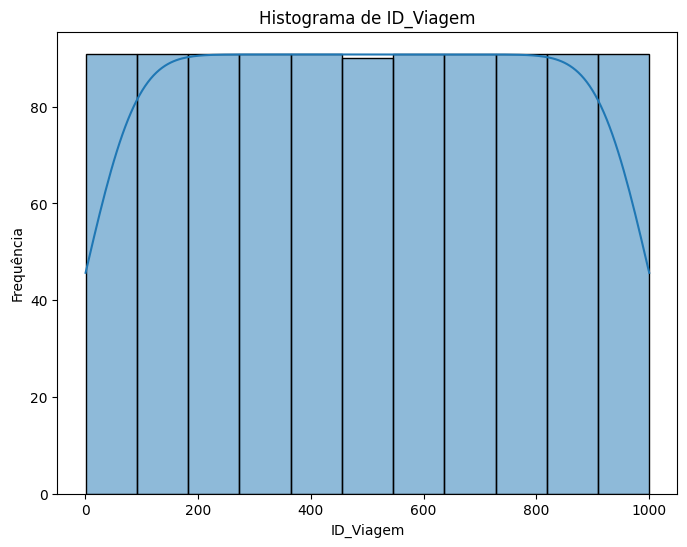

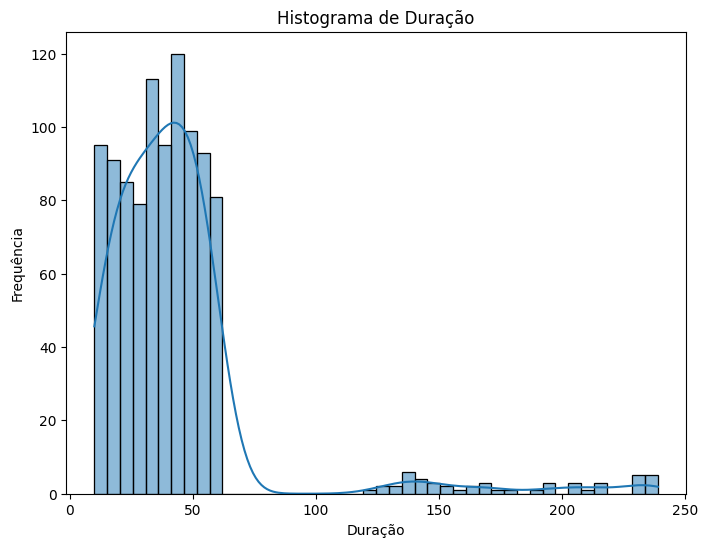

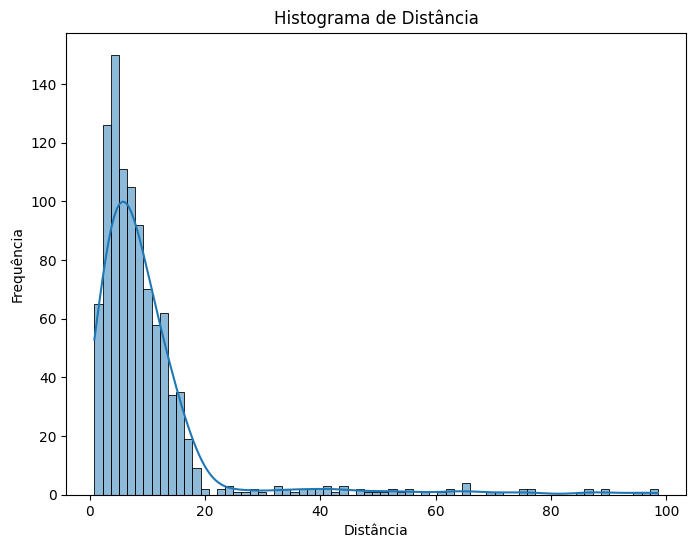

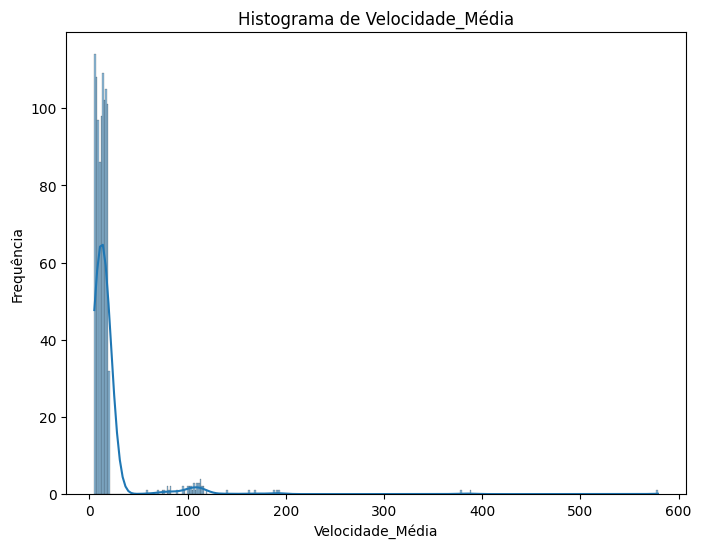

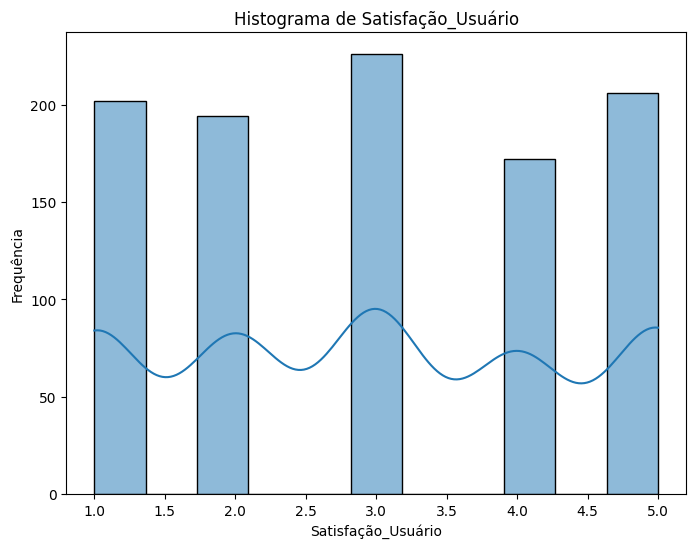

In [14]:
# Histogramas para colunas numéricas
numerical_columns = dataset.select_dtypes(include=np.number).columns.tolist()

for column in numerical_columns:
  plt.figure(figsize=(8, 6))
  sns.histplot(dataset[column], kde=True)
  plt.title(f"Histograma de {column}")
  plt.xlabel(column)
  plt.ylabel("Frequência")
  plt.show()

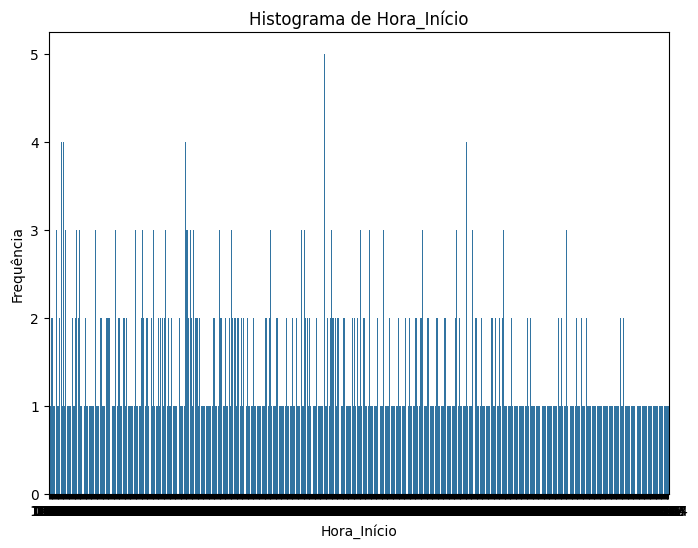

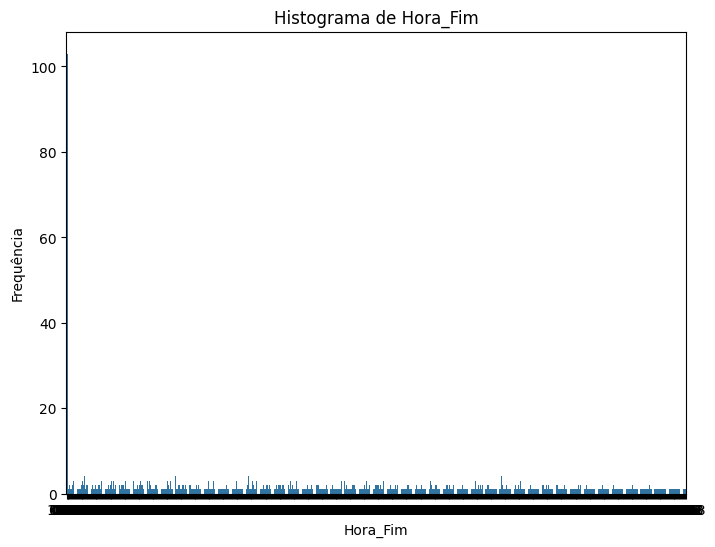

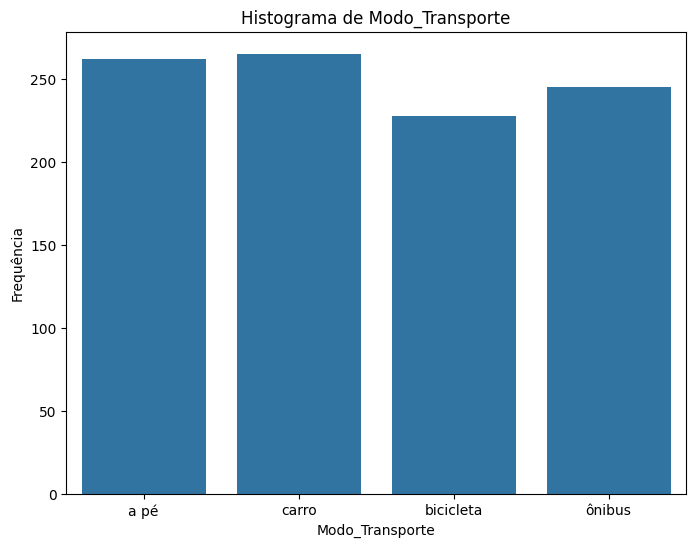

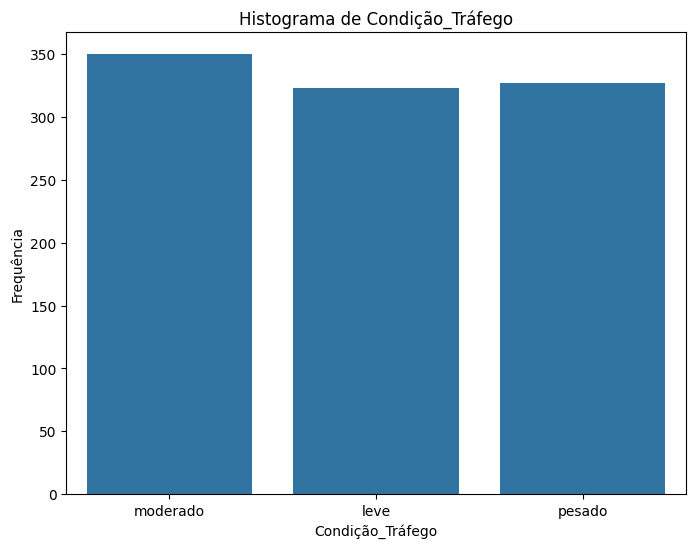

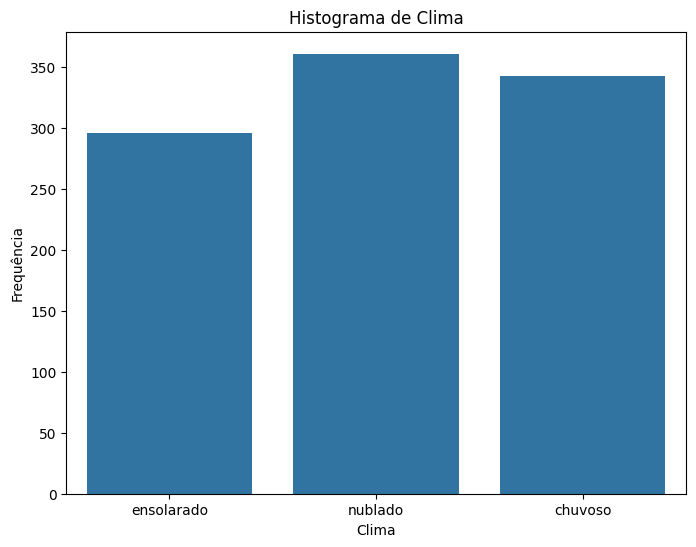

In [15]:
# Histogramas para colunas categóricas
categorical_columns = dataset.select_dtypes(include=['object']).columns.tolist()

for column in categorical_columns:
  plt.figure(figsize=(8, 6))
  sns.countplot(x=column, data=dataset)
  plt.title(f"Histograma de {column}")
  plt.xlabel(column)
  plt.ylabel("Frequência")
  plt.show()

### Dispersão

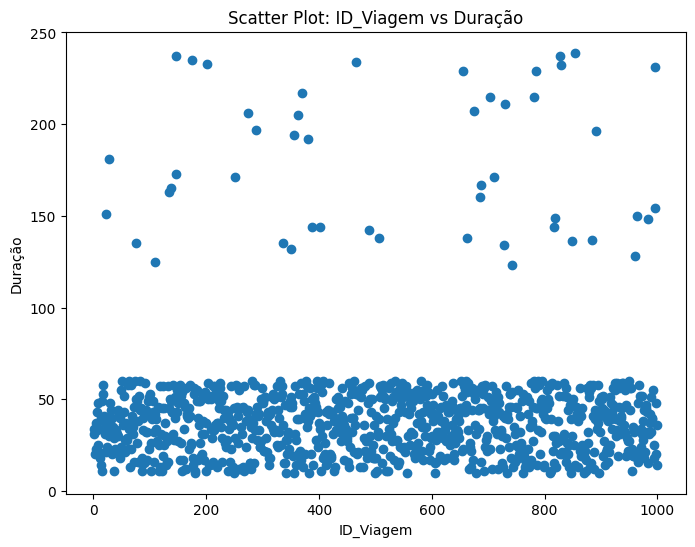

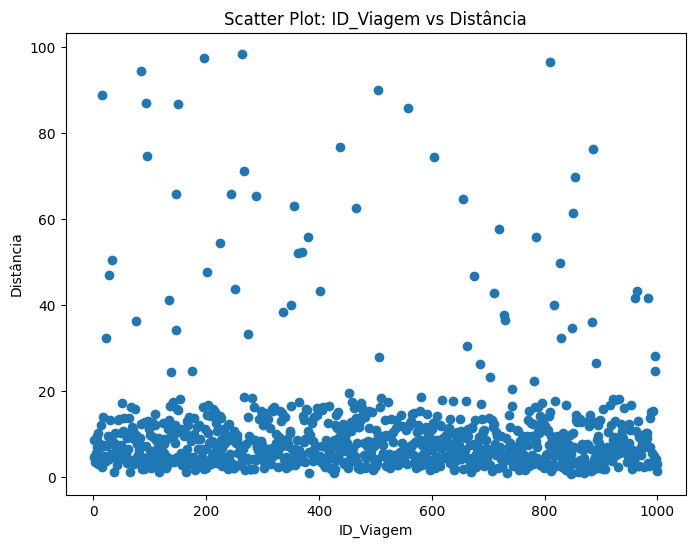

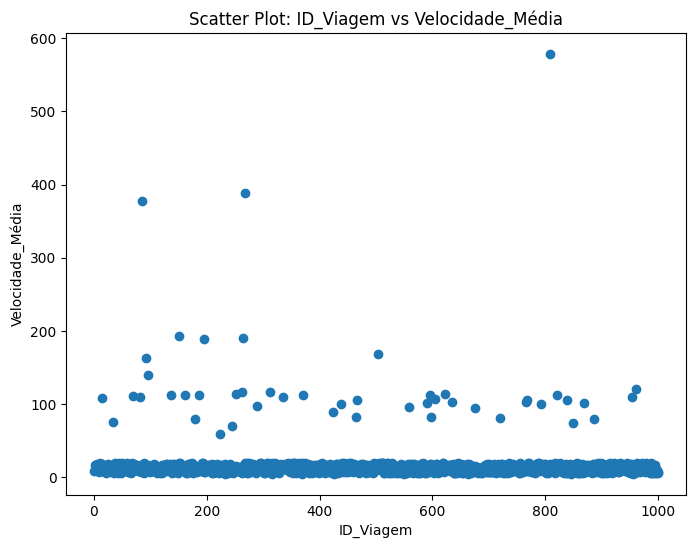

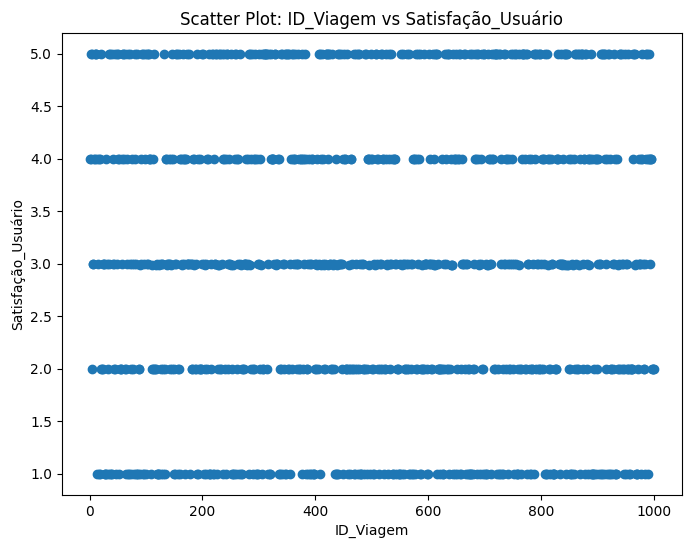

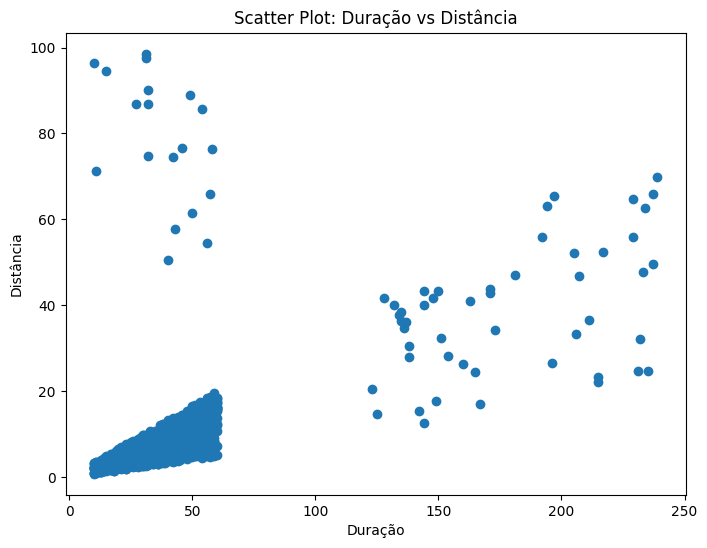

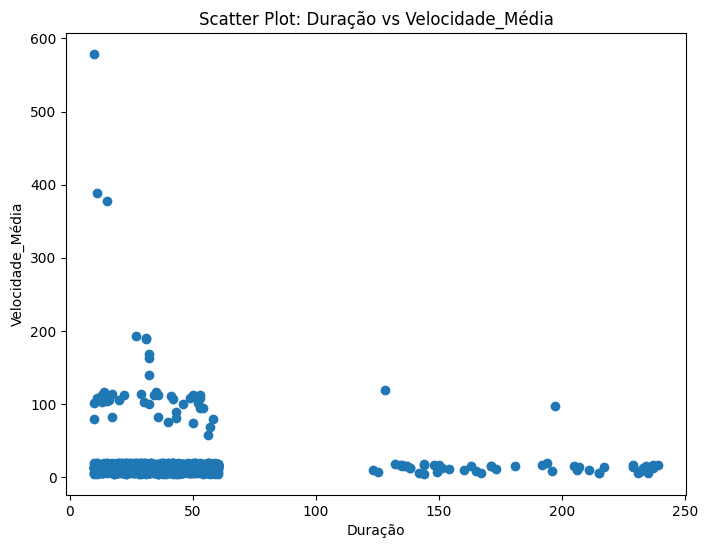

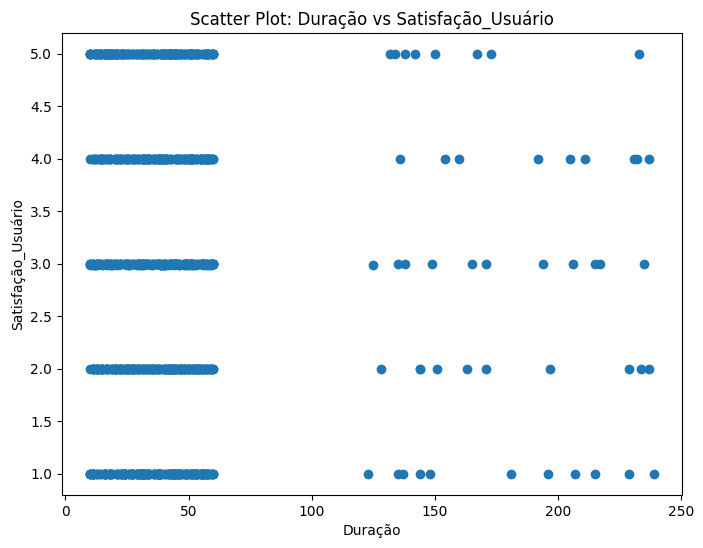

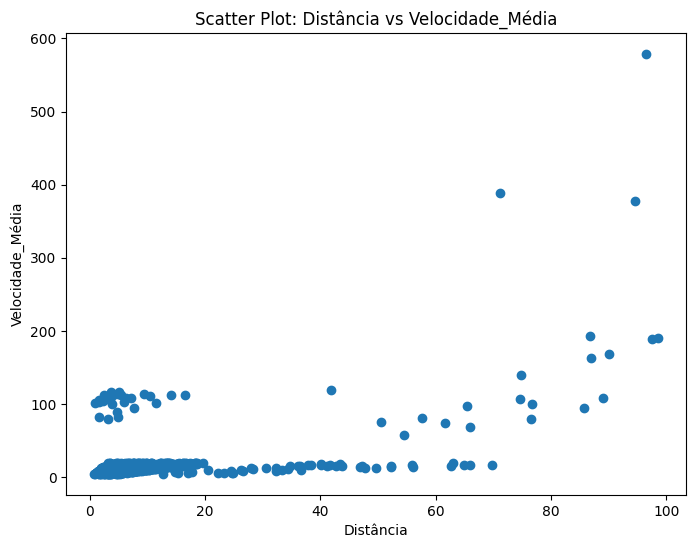

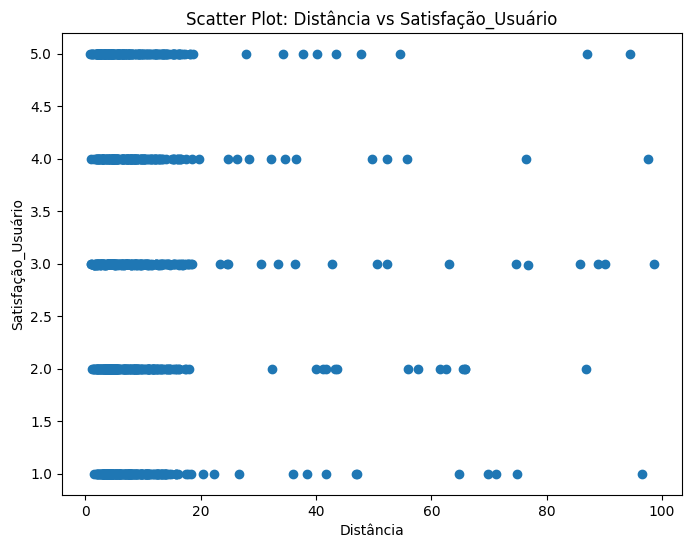

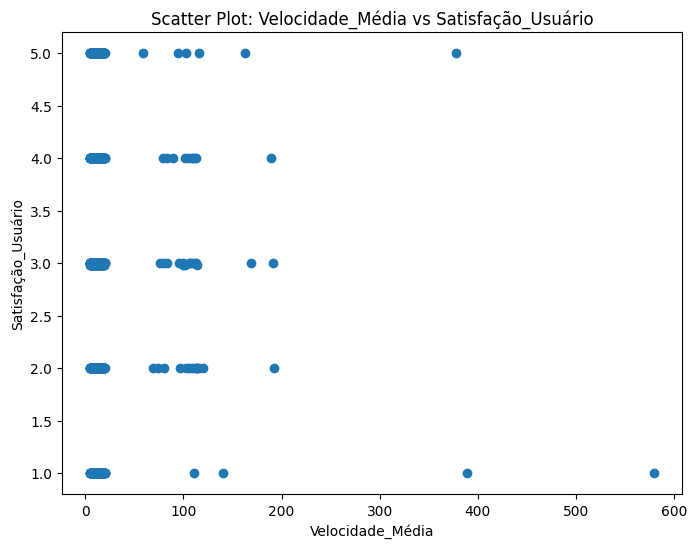

In [16]:
# Selecione colunas numéricas para gráficos de dispersão
numerical_columns = dataset.select_dtypes(include=np.number).columns.tolist()

# Crie gráficos de dispersão para pares de colunas numéricas
for i in range(len(numerical_columns)):
  for j in range(i + 1, len(numerical_columns)):
    plt.figure(figsize=(8, 6))
    plt.scatter(dataset[numerical_columns[i]], dataset[numerical_columns[j]])
    plt.xlabel(numerical_columns[i])
    plt.ylabel(numerical_columns[j])
    plt.title(f"Scatter Plot: {numerical_columns[i]} vs {numerical_columns[j]}")
    plt.show()

## Etapa 7: Identificação dos Outliers

### Identificação dos Outliers

In [ ]:
# Explicação: Para calcular o percentual de contaminação de outliers em um dataset, se pode usar o método InterQuartile Range (IQR) que serve para identificar os valores atípicos em cada coluna numérica. O IQR define outliers como valores que estão:
# Abaixo de Q1 - 1.5 x IQR
# Acima de Q3 + 1.5 x IQR

In [17]:
# Selecionar apenas colunas numéricas
numeric_cols = dataset.select_dtypes(include='number')

# Inicializar contador de outliers
outlier_counts = 0
total_values = numeric_cols.size

# Detectar outliers usando o método IQR para cada coluna numérica
for col in numeric_cols.columns:
    Q1 = numeric_cols[col].quantile(0.25)
    Q3 = numeric_cols[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Contar outliers
    col_outliers = numeric_cols[(numeric_cols[col] < lower_bound) | (numeric_cols[col] > upper_bound)][col].count()
    outlier_counts += col_outliers
    print(f"Coluna '{col}' - Outliers: {col_outliers}")

# Calcular o percentual de contaminação de outliers no dataset
outlier = (outlier_counts / total_values)
print("")
print(f"Percentual de contaminação de outliers no dataset: {outlier*100:.2f}%")
print(f"Valor de contaminação de outliers no dataset: {outlier:.4f}")

Coluna 'ID_Viagem' - Outliers: 0
Coluna 'Duração' - Outliers: 49
Coluna 'Distância' - Outliers: 62
Coluna 'Velocidade_Média' - Outliers: 48
Coluna 'Satisfação_Usuário' - Outliers: 0

Percentual de contaminação de outliers no dataset: 3.18%
Valor de contaminação de outliers no dataset: 0.0318


### Exibição do Boxplot


In [ ]:
# Explicação: Mediana (linha laranja no meio da caixa): representa a mediana do dado analisado, indicando que o 50% dos dados estão abaixo desse valor e 50% estão acima.
# Quartis (Q1 e Q3): a parte inferior da caixa representa o primeiro quartil (Q1), que é o valor abaixo do qual estão 25% dos dados e a parte superior da caixa representa o terceiro quartil (Q3), que é o valor abaixo do qual estão 75% dos dados.
# Intervalo Interquartil (IQR): é a altura da caixa representa, que representa a diferença entre Q3 e Q1. Esse intervalo cobre os 50% centrais dos dados.
# Limites (Bigodes): são as linhas verticais que se estendem até os valores que estão dentro de 1.5 x IQR de Q1 e Q3, sendo os limites para valores considerados "normais", pois os valores fora desses limites são considerados outliers.
# Outliers (círculos acima da caixa): serve para indicar que existem outliers, representando dados que estão bem acima da maioria dos demais, sendo assim, considerados valores extremos. Esses pontos representam indivíduos (observações) muito acima do restante do conjunto de dados.

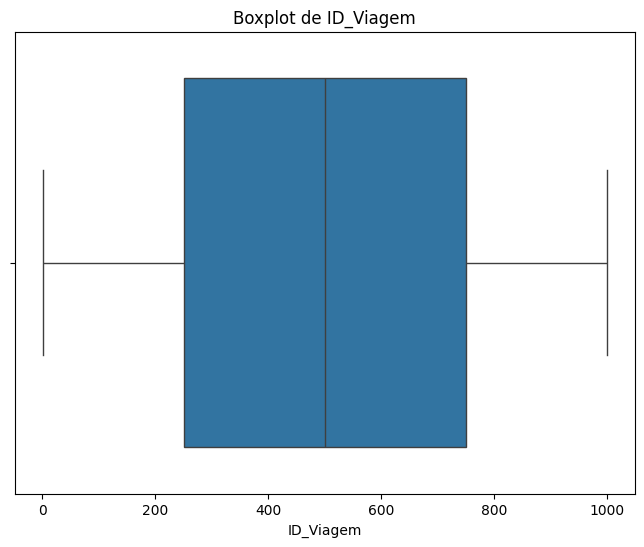

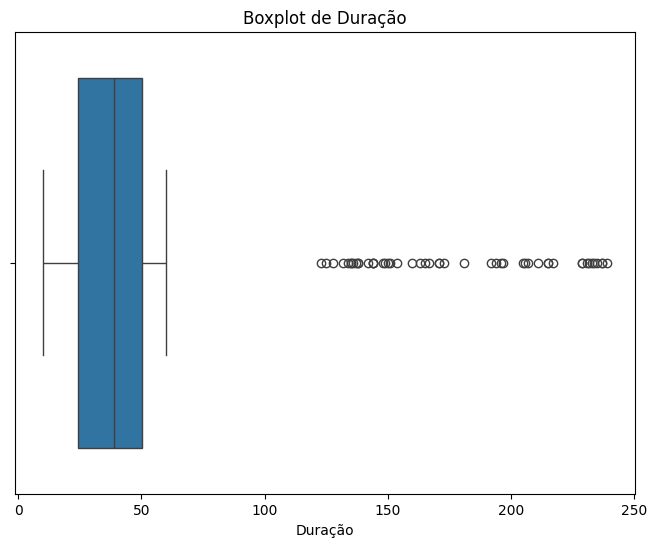

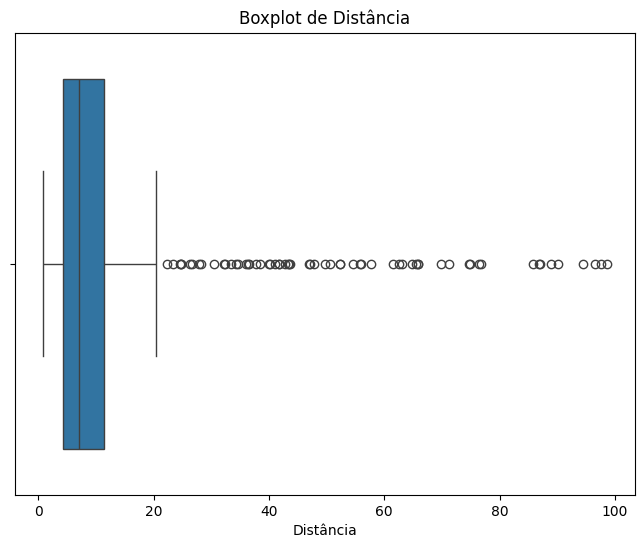

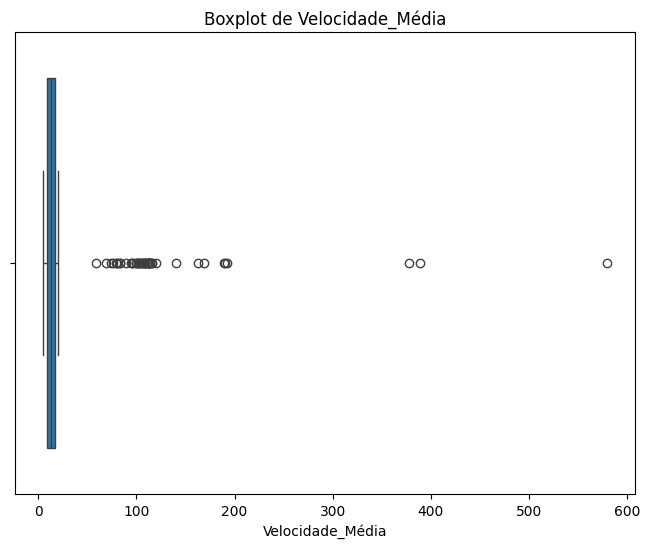

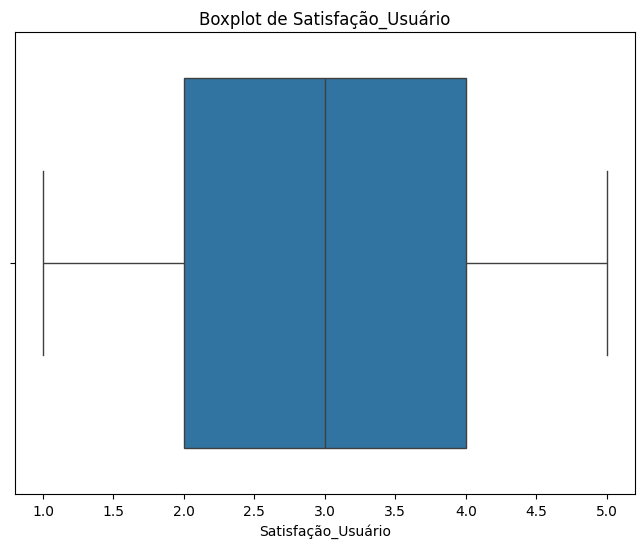

In [18]:
# Criar boxplot para cada coluna numérica para visualizar outliers
numeric_cols = dataset.select_dtypes(include='number')

# Criar boxplots para cada coluna numérica
for column in numeric_cols.columns:
  plt.figure(figsize=(8, 6))
  sns.boxplot(x=dataset[column])
  plt.title(f"Boxplot de {column}")
  plt.show()

### Visualização da distribuição dos dados outliers e inliers

In [19]:
# Criar um modelo IsolationForest com o percentual de contaminação definido
contamination = outlier  # Use o valor de 'outlier' calculado anteriormente

# Crie o modelo IsolationForest
model_isolation_forest = IsolationForest(contamination=contamination, random_state=42)

# Treine o modelo com o conjunto de dados (apenas colunas numéricas)
numeric_cols = dataset.select_dtypes(include='number')
model_isolation_forest.fit(numeric_cols)

# Obtenha as previsões do modelo (1 para inliers, -1 para outliers)
predictions = model_isolation_forest.predict(numeric_cols)

# Adicione as previsões ao DataFrame original
dataset['outlier'] = predictions

# Exibir o DataFrame com a coluna 'outlier'
print(dataset.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  outlier
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0        1
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0        1
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0        1
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0        1
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0        1


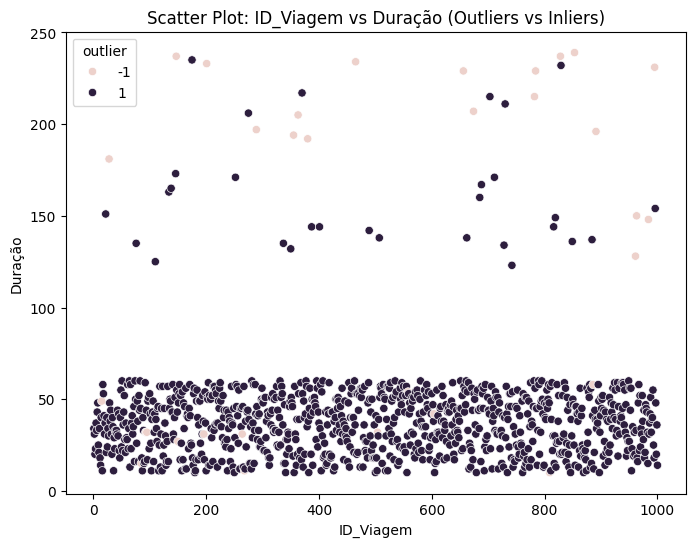

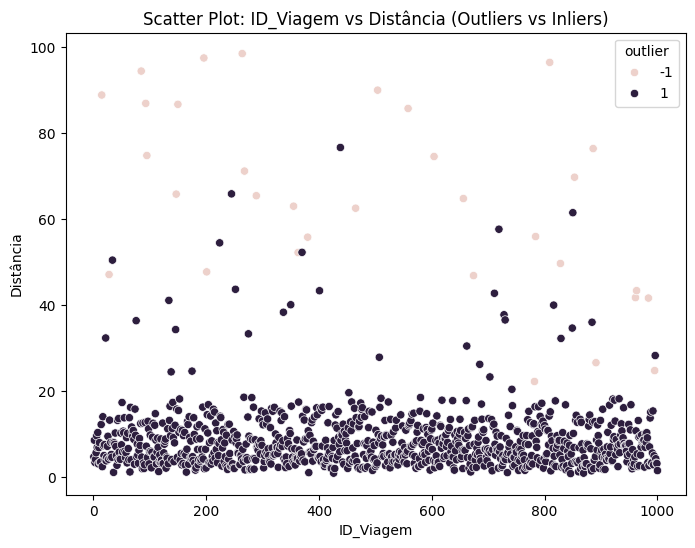

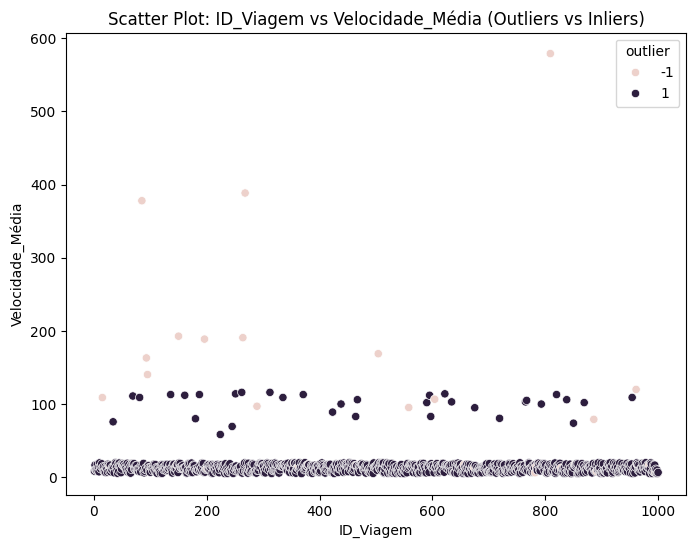

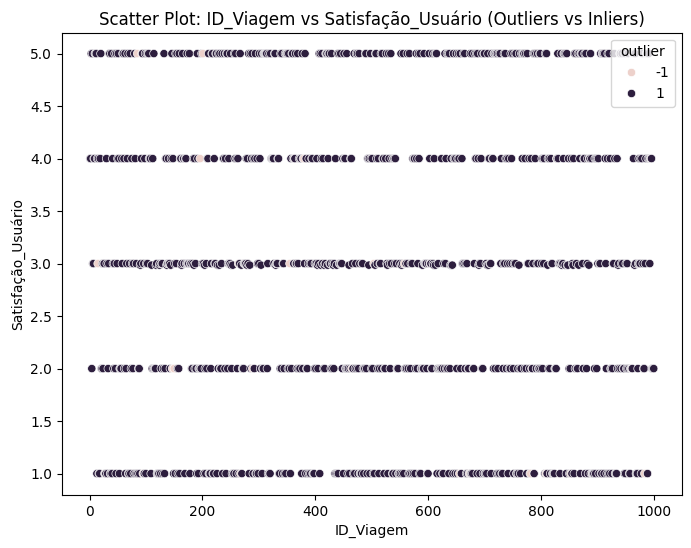

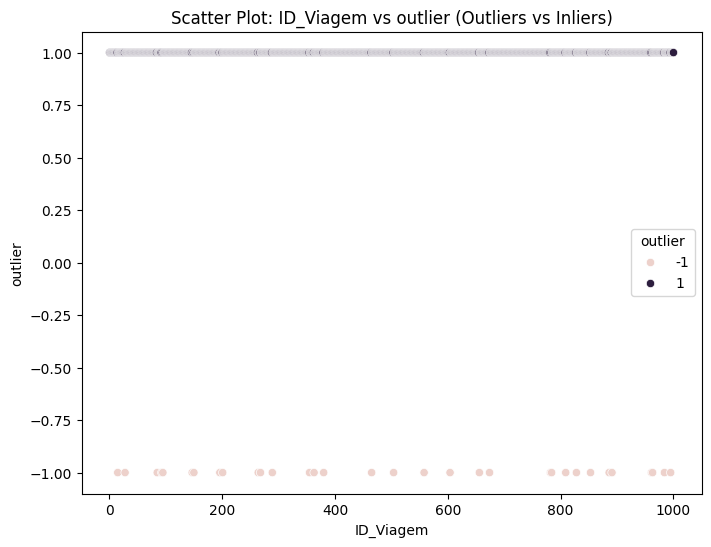

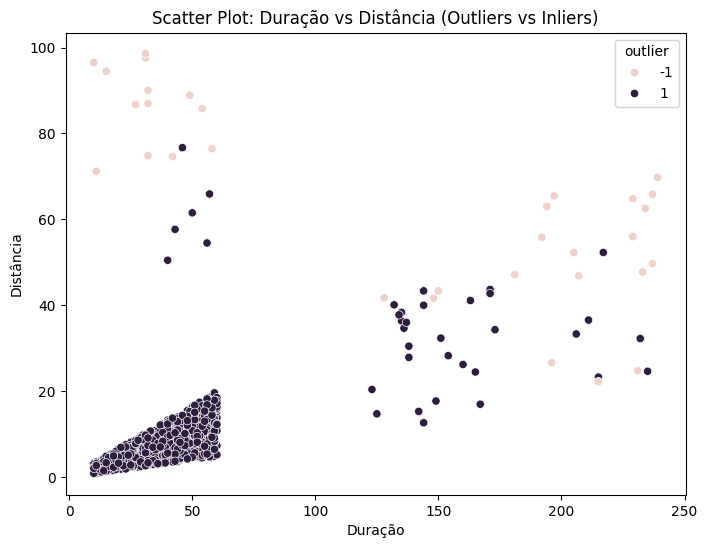

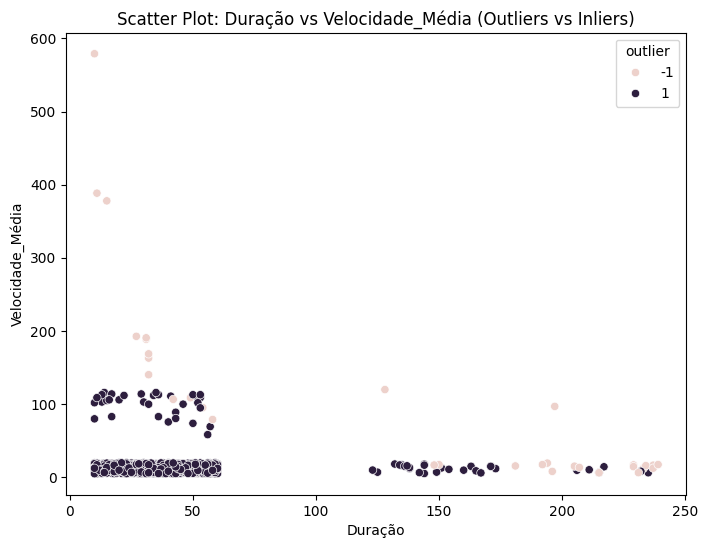

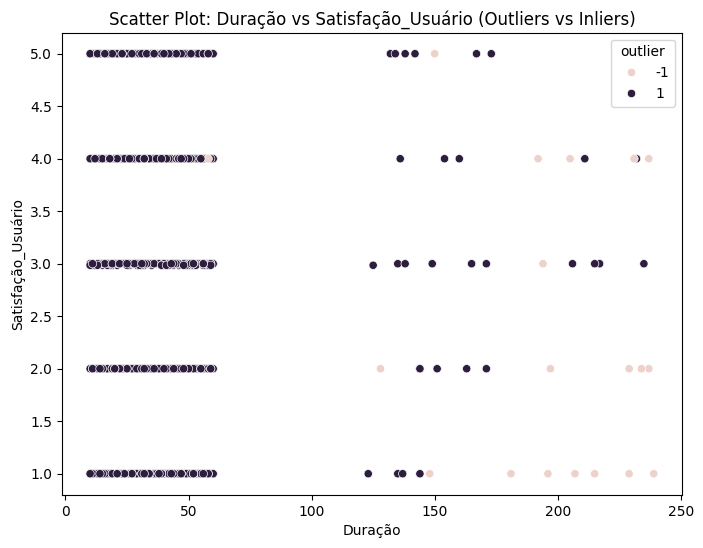

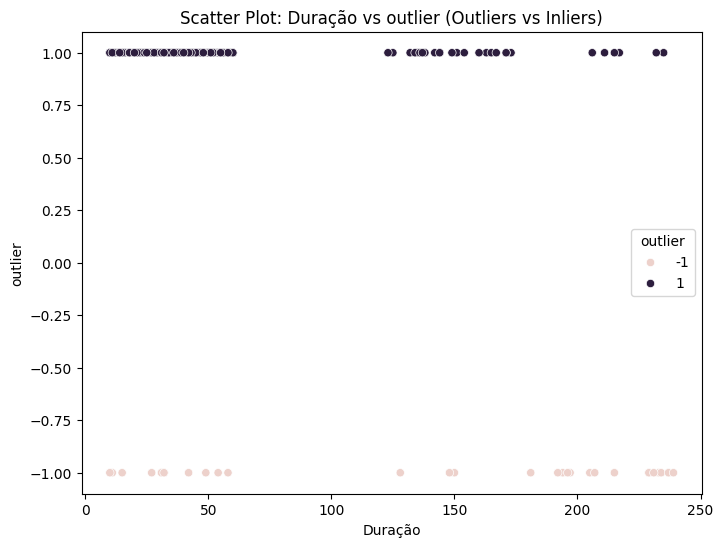

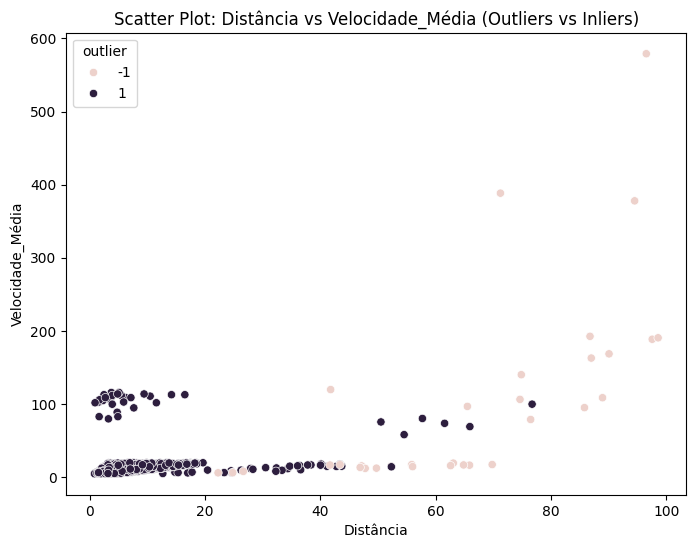

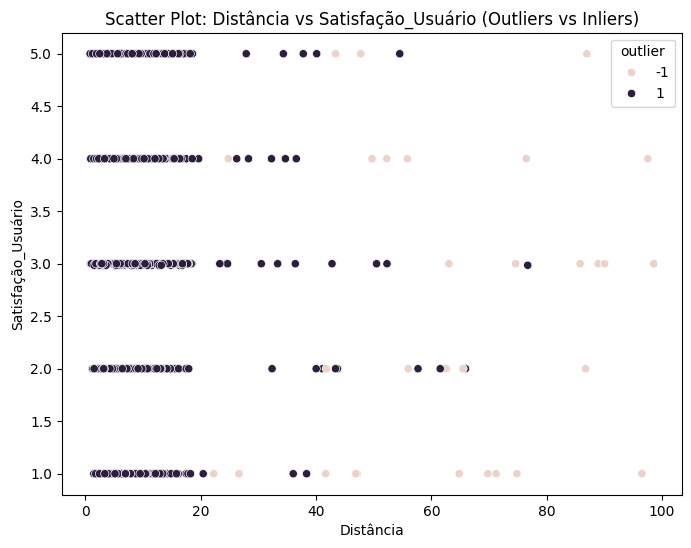

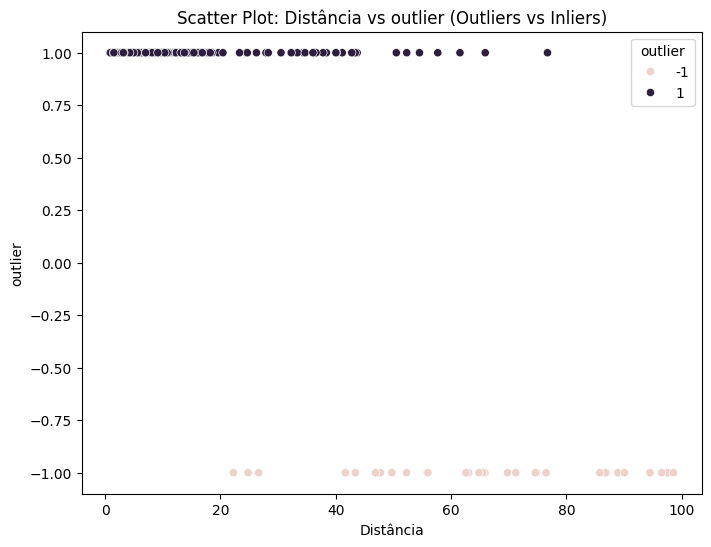

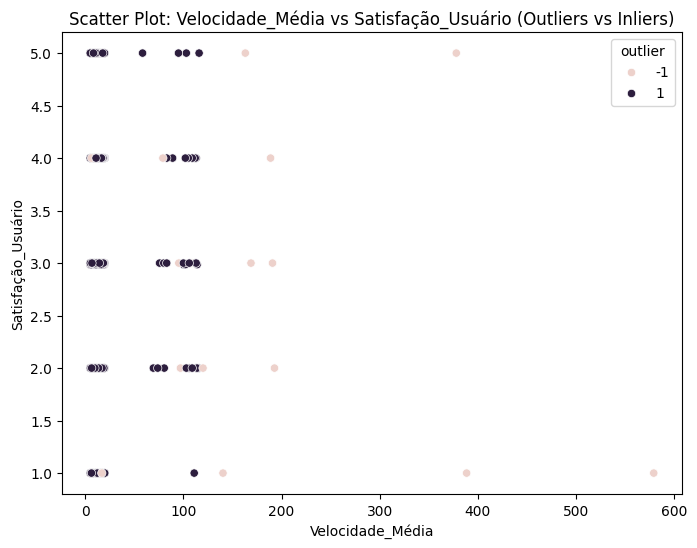

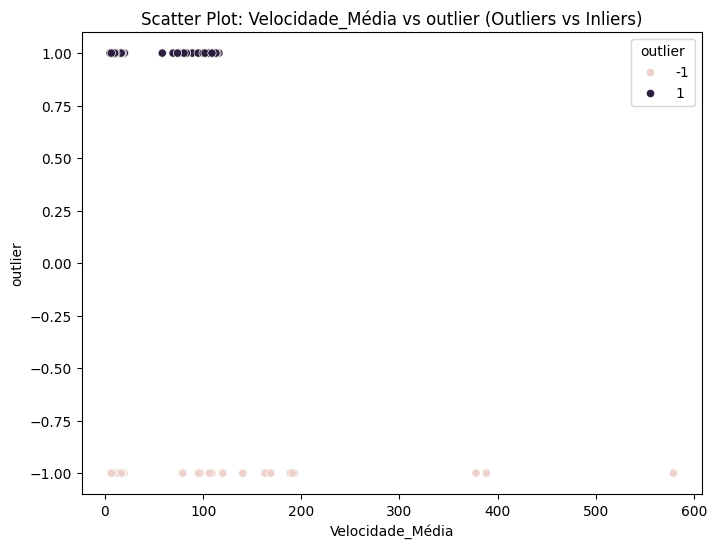

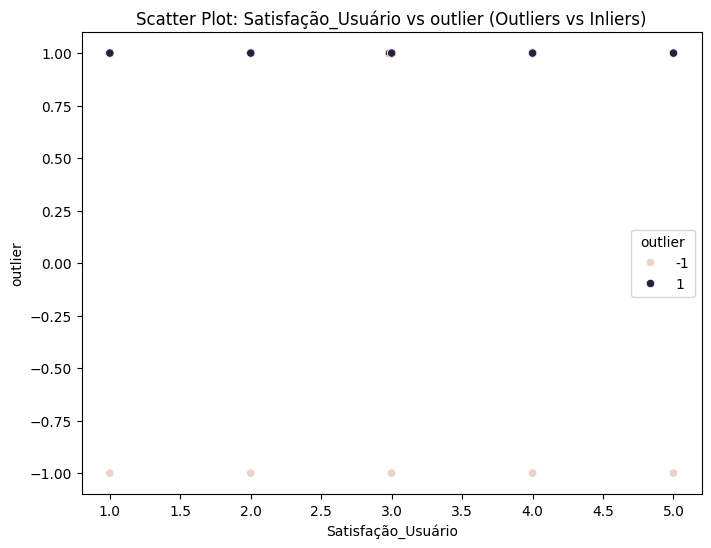

In [20]:
# Selecione as colunas numéricas para o gráfico de dispersão
numerical_columns = dataset.select_dtypes(include=np.number).columns.tolist()

# Crie um gráfico de dispersão para cada par de colunas numéricas, colorindo os outliers e inliers
for i in range(len(numerical_columns)):
  for j in range(i + 1, len(numerical_columns)):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=dataset[numerical_columns[i]], y=dataset[numerical_columns[j]], hue=dataset['outlier'])
    plt.xlabel(numerical_columns[i])
    plt.ylabel(numerical_columns[j])
    plt.title(f"Scatter Plot: {numerical_columns[i]} vs {numerical_columns[j]} (Outliers vs Inliers)")
    plt.show()

### Separação dos Outliers dos Inliers

In [21]:
# Selecionar apenas colunas numéricas para a detecção de outliers
numeric_data = dataset.select_dtypes(include='number')

# Configurar e aplicar o Isolation Forest com contaminação
iso_forest = IsolationForest(contamination=outlier, random_state=42)
outlier_labels = iso_forest.fit_predict(numeric_data)

# Adicionar os rótulos de outliers ao dataset
dataset['is_outlier'] = outlier_labels

# Filtrar apenas os outliers (rótulo -1)
outliers = dataset[dataset['is_outlier'] == -1]

# Exibir os dados que são outliers
print("Dados identificados como outliers:")
print(outliers.to_string())

# Exibir a quantidade de outliers detectados
outlier_count = len(outliers)
print(f"\nTotal de outliers: {outlier_count}")

Dados identificados como outliers:
     ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  outlier  is_outlier
14          15       19:28    20:17       49      88.92          ônibus            108.88           pesado     chuvoso                 3.0       -1          -1
27          28       12:11    15:12      181      47.15          ônibus             15.63             leve     chuvoso                 1.0       -1          -1
84          85       06:59    07:14       15      94.49          ônibus            377.96           pesado     nublado                 5.0       -1          -1
92          93       07:29    08:01       32      86.97            a pé            163.07             leve     nublado                 5.0       -1          -1
94          95       08:31    02:35       32      74.84          ônibus            140.33         moderado     nublado                 1.0       -1          -1
146  

In [22]:
# Remover os outliers
try:
    dataset = dataset[dataset['is_outlier'] == 1].drop(columns=['is_outlier'])
except Exception as e:
    print(f"Ocorreu um erro: {e}")

In [23]:
# Remover a coluna 'Outlier' do dataset
if 'outlier' in dataset.columns:
  dataset = dataset.drop('outlier', axis=1)

# Remover a coluna 'is_outlier' do dataset
if 'is_outlier' in dataset.columns:
  dataset = dataset.drop('is_outlier', axis=1)

In [24]:
# Exibir o dataset sem os outliers
print("Dataset sem os outliers:")
print(dataset.head().to_string())

# Exibir informações gerais do dataset
print("\nInformações Gerais do Dataset:")
print(dataset.info())

Dataset sem os outliers:
   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0

Informações Gerais do Dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 968 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          

## Etapa 8: Preprocessamento de Dados (Regras, Codificação e Normalização)

### Rules

In [25]:
# Definir a primeira coluna como meta, a última coluna como target e as demais como features
meta = dataset.columns[0]
target = dataset.columns[-1]
features = dataset.columns[1:-1]

print(f"Meta: {meta}")
print(f"Target: {target}")
print(f"Features: {features.tolist()}")

Meta: ID_Viagem
Target: Satisfação_Usuário
Features: ['Hora_Início', 'Hora_Fim', 'Duração', 'Distância', 'Modo_Transporte', 'Velocidade_Média', 'Condição_Tráfego', 'Clima']


### Encoding

In [ ]:
# Técnicas de Encoding
# Label Encoding: Simples e direto, útil para variáveis ordinais.
# One-Hot Encoding: Ideal para variáveis nominais com poucas categorias.
# Binary Encoding: Reduz o número de colunas para variáveis com muitas categorias.
# Target Encoding: Útil para problemas supervisionados, especialmente com muitas categorias.
# Frequency Encoding: Captura a frequência das categorias.
# Ordinal Encoding: Para variáveis categóricas com ordem.
# Hash Encoding: Útil para um número muito grande de categorias, porém pode introduzir colisões.

#### Label Encoding

In [26]:
# Label Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Criar um objeto LabelEncoder
le = LabelEncoder()

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Aplicar Label Encoding na coluna atual
  datasetx[column] = le.fit_transform(datasetx[column])

# Exibir o datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Label Encoding):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0
Datasetx com colunas categóricas transformadas em numéricas (Label Encoding):
   ID_Viagem  Hora_Início  Hora_Fim  Duração  Distância  Modo_Transporte  Velocidade_Média  Condição

#### One-Hot Encoding

In [27]:
# One-Hot Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Aplicar One-Hot Encoding na coluna atual
  datasetx = pd.get_dummies(datasetx, columns=[column], prefix=[column])

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (One-Hot Encoding):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0
Datasetx com colunas categóricas transformadas em numéricas (One-Hot Encoding):
   ID_Viagem  Duração  Distância  Velocidade_Média  Satisfação_Usuário  Hora_Início_00:00  Hora_In

#### Binary Encoding

In [28]:
# Binary Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Criar um dicionário para mapear categorias para valores binários
  unique_categories = datasetx[column].unique()
  category_mapping = {category: bin(i)[2:].zfill(len(bin(len(unique_categories) - 1)[2:])) for i, category in enumerate(unique_categories)}

  # Aplicar Binary Encoding na coluna atual
  datasetx[column] = datasetx[column].map(category_mapping)

  # Separar as colunas binárias criadas
  for bit_index in range(len(bin(len(unique_categories) - 1)[2:])):
    new_column_name = f"{column}_bit_{bit_index + 1}"
    datasetx[new_column_name] = datasetx[column].str[bit_index].astype(int)

  # Remover a coluna original com a representação binária
  datasetx = datasetx.drop(columns=[column])

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Binary Encoding):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0
Datasetx com colunas categóricas transformadas em numéricas (Binary Encoding):
   ID_Viagem  Duração  Distância  Velocidade_Média  Satisfação_Usuário  Hora_Início_bit_1  Hora_Iní

#### Target Encoding

In [29]:
# Target Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Verificar se a coluna 'target' é numérica
if not pd.api.types.is_numeric_dtype(datasetx[target]):
  # Se não for numérica, aplicar Label Encoding
  le = LabelEncoder()
  datasetx[target] = le.fit_transform(datasetx[target])

# Aplicar Target Encoding
for column in datasetx.select_dtypes(include=['object']):
  if column != target:  # Evitar aplicar Target Encoding na coluna 'target'
    target_mean = datasetx.groupby(column)[target].mean()
    datasetx[column] = datasetx[column].map(target_mean)

# Exibir o datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Target Encoding):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0
Datasetx com colunas categóricas transformadas em numéricas (Target Encoding):
   ID_Viagem  Hora_Início  Hora_Fim  Duração  Distância  Modo_Transporte  Velocidade_Média  Condiçã

#### Frequency Encoding

In [30]:
# Frequency Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Calcular a frequência de cada categoria na coluna atual
  frequency_encoding = datasetx.groupby(column)[column].transform('count') / len(datasetx)

  # Substituir as categorias pelos valores codificados (frequência)
  datasetx[column] = frequency_encoding

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Frequency Encoding):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0
Datasetx com colunas categóricas transformadas em numéricas (Frequency Encoding):
   ID_Viagem  Hora_Início  Hora_Fim  Duração  Distância  Modo_Transporte  Velocidade_Média  Cond

#### Hash Encoding

In [31]:
# Hash Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Aplicar Hash Encoding na coluna atual
  datasetx[column] = datasetx[column].apply(hash)

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Hash Encoding):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0
Datasetx com colunas categóricas transformadas em numéricas (Hash Encoding):
   ID_Viagem          Hora_Início             Hora_Fim  Duração  Distância      Modo_Transporte  Velo

#### Ordinal Encoding

In [32]:
# Ordinal Encoding
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas categóricas do datasetx
for column in datasetx.select_dtypes(include=['object']):
  # Criar um dicionário para mapear categorias para valores ordinais
  unique_categories = datasetx[column].unique()
  category_mapping = {category: i for i, category in enumerate(unique_categories)}

  # Aplicar Ordinal Encoding na coluna atual
  datasetx[column] = datasetx[column].map(category_mapping)

# Exibir o cabeçalho do datasetx com as colunas categóricas transformadas em numéricas
print("Datasetx com colunas categóricas transformadas em numéricas (Ordinal Encoding):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0
3          4       16:28    16:51       23       4.12       bicicleta             10.75         moderado     chuvoso                 2.0
4          5       07:53    08:30       37       5.68          ônibus              9.21             leve  ensolarado                 5.0
Datasetx com colunas categóricas transformadas em numéricas (Ordinal Encoding):
   ID_Viagem  Hora_Início  Hora_Fim  Duração  Distância  Modo_Transporte  Velocidade_Média  Condiç

#### Codificação

In [33]:
# Iterar sobre as colunas numéricas, excluindo a primeira coluna
for column in dataset.select_dtypes(include=np.number).columns[1:]:
  # Criar um novo objeto LabelEncoder para cada coluna
  le = LabelEncoder()

  # Ajustar e transformar os valores da coluna, criando um novo campo com o nome '_encoded'
  dataset[column + '_encoded'] = le.fit_transform(dataset[column])

# Exibir o dataset com as novas colunas de label encoding
print("Dataset com label encoding das features numéricas:")
print(dataset.head().to_string())

Dataset com label encoding das features numéricas:
   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       2

### Normalize

In [ ]:
# Técnicas de normalização
# Z-Score Normalization: Centraliza dados em torno da média 0 e desvio padrão 1.
# Max Abs Scaling: Escala pelo valor absoluto máximo, útil para dados com média próxima de 0.
# L1/L2 Normalization: Usa normas para normalizar os dados em relação à soma absoluta ou quadrática.
# Robust Scaling: Usa a mediana e IQR, ideal para dados com outliers.
# Log Transformation: Reduz a escala de valores grandes e ajusta distribuições distorcidas.
# Power Transformations: Ajusta distribuições para se aproximarem de uma normal.
# Min-Max Scaling: Escala os dados entre um intervalo específico (0-1, geralmente).

#### Power Transformations

In [34]:
# Power Transformations
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Selecionar apenas colunas numéricas para a normalização
numeric_cols = datasetx.select_dtypes(include=['number']).columns

# Criar um objeto PowerTransformer
pt = PowerTransformer()

# Aplicar Power Transformations às colunas numéricas
datasetx[numeric_cols] = pt.fit_transform(datasetx[numeric_cols])

# Exibir o dataset normalizado
print("Dataset normalizado com Power Transformations:")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       23       4.12       bicicleta             10.75     

#### Log Transformation

In [35]:
# Log Transformation
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Iterar pelas colunas numéricas do datasetn
for column in datasetx.select_dtypes(include=['number']):
  # Aplicar Log Transformation na coluna atual, tratando possíveis valores negativos
  datasetx[column] = np.log1p(datasetx[column])

# Exibir o datasetn com as colunas numéricas normalizadas
print("Dataset com colunas numéricas normalizadas (Log Transformation):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       23       4.12       bicicleta             10.75     

#### Robust Scaling

In [36]:
# Robust Scaling
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Selecionar as colunas numéricas para normalização
numerical_cols = datasetx.select_dtypes(include=np.number).columns

# Criar um objeto RobustScaler
scaler = RobustScaler()

# Aplicar Robust Scaling às colunas numéricas
datasetx[numerical_cols] = scaler.fit_transform(datasetx[numerical_cols])

# Exibir o datasetn com as features normalizadas
print("Datasetn com features normalizadas (Robust Scaling):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       23       4.12       bicicleta             10.75     

#### L1 Normalization

In [37]:
# L1 Normalization
datasetx = dataset.copy()
print(datasetx.head().to_string())

# L1 Normalization
for column in datasetx.select_dtypes(include=['number']):
    datasetx[column] = datasetx[column] / np.linalg.norm(datasetx[column], ord=1)

print("Dataset com features normalizadas (L1):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       23       4.12       bicicleta             10.75     

#### Max Abs Scaling

In [38]:
# Max Abs Scaling
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Normalizar as features usando Max Abs Scaling
for column in datasetx.columns:
  if pd.api.types.is_numeric_dtype(datasetx[column]):
    # Aplicar Max Abs Scaling à coluna atual
    datasetx[column] = datasetx[column] / datasetx[column].abs().max()

# Exibir o dataset normalizado
print("Dataset normalizado com Max Abs Scaling:")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       23       4.12       bicicleta             10.75     

#### Z-Score Normalization

In [39]:
# Z-Score Normalization
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Criar um objeto StandardScaler
scaler = StandardScaler()

# Iterar pelas colunas numéricas do datasetx
for column in datasetx.select_dtypes(include=['number']):
  # Aplicar Z-Score Normalization na coluna atual
  datasetx[column] = scaler.fit_transform(datasetx[[column]])

# Exibir o datasetx com as colunas numéricas normalizadas
print("Dataset com colunas numéricas normalizadas (Z-Score Normalization):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       23       4.12       bicicleta             10.75     

#### MinMaxScaler

In [40]:
# MinMaxScaler
datasetx = dataset.copy()
print(datasetx.head().to_string())

# Criar um objeto MinMaxScaler
scaler = MinMaxScaler()

# Iterar pelas colunas numéricas do datasetx
datasetx[numerical_cols] = scaler.fit_transform(datasetx[numerical_cols])

# Exibir o datasetx normalizado
print("Datasetn com colunas numéricas normalizadas (MinMaxScaler):")
print(datasetx.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4
1          2       15:12    02:35       31       8.59            a pé             16.63         moderado     nublado                 4.0               21                406                       536                           4
2          3       16:34    16:54       20       3.42           carro             10.26         moderado     nublado                 5.0               10                111                       254                           5
3          4       16:28    16:51       23       4.12       bicicleta             10.75     

#### Normalizing

In [41]:
# MinMaxScaler
scaler = MinMaxScaler()

# Iterar pelas colunas numéricas do datasetx
for column in dataset.select_dtypes(include=['number']):
  # Aplicar MinMaxScaler na coluna atual e criar um novo campo com o sufixo "_minmax"
  dataset[column + '_minmax'] = scaler.fit_transform(dataset[[column]])

# Exibir o datasetx com os novos campos normalizados
print("Dataset com novos campos normalizados com MinMaxScaler:")
print(dataset.head().to_string())

Dataset com novos campos normalizados com MinMaxScaler:
   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded  ID_Viagem_minmax  Duração_minmax  Distância_minmax  Velocidade_Média_minmax  Satisfação_Usuário_minmax  Duração_encoded_minmax  Distância_encoded_minmax  Velocidade_Média_encoded_minmax  Satisfação_Usuário_encoded_minmax
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4          0.000000        0.106667          0.051397                 0.030355                       0.75                0.320000                  0.285511                         0.237216                                0.8
1          2       15:12    02:35       31    

## Etapa 9: Redução da Dimensionalidade

In [42]:
# Verificar se as colunas 'pc1' e 'pc2' já existem no dataset
if 'pc1' not in dataset.columns or 'pc2' not in dataset.columns:
  # Selecionar apenas as colunas com sufixo '_minmax'
  minmax_columns = [col for col in dataset.columns if col.endswith('_minmax')]
  dataset_minmax = dataset[minmax_columns]

  # Substituir valores NaN por 0
  dataset_minmax = dataset_minmax.fillna(0)

  # Aplicar PCA com 2 componentes principais
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(dataset_minmax)

  # Criar as colunas 'pc1' e 'pc2' no dataset original com os componentes principais
  dataset['pc1'] = principal_components[:, 0]
  dataset['pc2'] = principal_components[:, 1]
else:
  # Se as colunas 'pc1' e 'pc2' já existem, atualizar os valores com os novos componentes principais
  minmax_columns = [col for col in dataset.columns if col.endswith('_minmax')]
  dataset_minmax = dataset[minmax_columns]

  # Substituir valores NaN por 0
  dataset_minmax = dataset_minmax.fillna(0)

  # Aplicar PCA com 2 componentes principais
  pca = PCA(n_components=2)
  principal_components = pca.fit_transform(dataset_minmax)

  # Atualizar os valores das colunas 'pc1' e 'pc2'
  dataset['pc1'] = principal_components[:, 0]
  dataset['pc2'] = principal_components[:, 1]
print(dataset.head().to_string())

   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded  ID_Viagem_minmax  Duração_minmax  Distância_minmax  Velocidade_Média_minmax  Satisfação_Usuário_minmax  Duração_encoded_minmax  Distância_encoded_minmax  Velocidade_Média_encoded_minmax  Satisfação_Usuário_encoded_minmax       pc1       pc2
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4          0.000000        0.106667          0.051397                 0.030355                       0.75                0.320000                  0.285511                         0.237216                                0.8  0.390756 -0.282869
1          2       15:12    02:35       31       8.59         

## Etapa 10: Clusterização

### Técnicas para identificação do hiperparametro K

In [ ]:
# Explicação: Método da Silhueta para escolher o valor de K que maximiza a separação entre clusters e a coesão dentro de cada cluster.

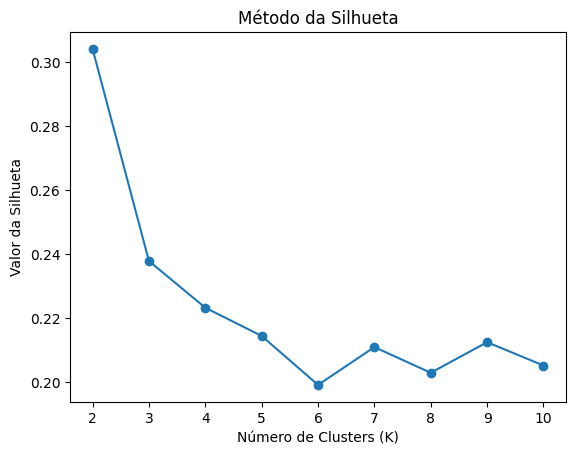

Melhor valor de K (Método da Silhueta): 2


In [43]:
# Selecionar apenas as colunas com o sufixo "_minmax"
df_minmax = dataset[[col for col in dataset.columns if col.endswith('_minmax')]]
df_minmax = df_minmax.dropna()

# Lista para armazenar os valores de silhueta para diferentes valores de K
silhouette_avg = []

# Testar valores de K de 2 a 10
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(df_minmax)
    silhouette_avg.append(silhouette_score(df_minmax, cluster_labels))

# Plotar o gráfico da silhueta
plt.plot(range(2, 11), silhouette_avg, marker='o')
plt.title('Método da Silhueta')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Valor da Silhueta')
plt.show()

# Encontrar o melhor valor de K (o valor de K que maximiza a silhueta)
best_k = np.argmax(silhouette_avg) + 2

print(f"Melhor valor de K (Método da Silhueta): {best_k}")

In [ ]:
# Explicação: Método do Cotovelo para determinar o valor de K ao observar o ponto em que a "inércia" (soma das distâncias ao centroide) começa a diminuir menos significativamente conforme K aumenta.

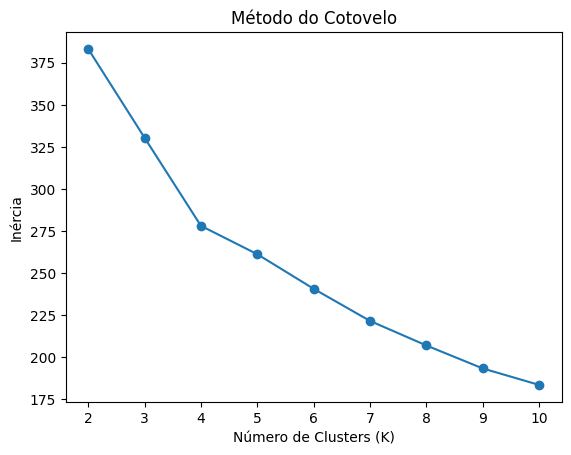

Melhor valor de K (Método do Cotovelo): 2


In [44]:
# Selecionar apenas as colunas com o sufixo "_minmax"
df_minmax = dataset[[col for col in dataset.columns if col.endswith('_minmax')]]
df_minmax = df_minmax.dropna()  # Remover linhas com valores NaN

# Lista para armazenar a inércia para diferentes valores de K
inertia = []

# Testar valores de K de 2 a 10
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(df_minmax)
  inertia.append(kmeans.inertia_)

# Plotar o gráfico do cotovelo
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inércia')
plt.show()

# Encontrar o melhor valor de K (o ponto de inflexão no gráfico)
# Pode ser feito visualmente ou usando alguma técnica de detecção de inflexão
# Neste exemplo, vamos usar a visualização para determinar o melhor K
# O melhor K parece ser 3, mas isso depende do gráfico gerado.
best_k = np.argmin(np.diff(inertia)) + 2  # Encontrar o ponto de inflexão
print(f"Melhor valor de K (Método do Cotovelo): {best_k}")

### Algoritmo de Clusterização (KMeans)

In [45]:
# Definir os hiperparâmetros do KMeans
kmeans_params = {
    'n_clusters': best_k,  # Número de clusters (obtido pelo método do cotovelo ou silhueta)
    'init': 'k-means++',  # Método de inicialização dos centroides
    'n_init': 100,  # Número de vezes que o algoritmo é executado com diferentes inicializações
    'max_iter': 1000,  # Número máximo de iterações do algoritmo
    'tol': 1e-4,  # Tolerância para a convergência do algoritmo
    'random_state': 42  # Seed para a reprodutibilidade dos resultados
}

In [46]:
# Selecionar apenas as colunas com o sufixo "_minmax"
df_minmax = dataset[[col for col in dataset.columns if col.endswith('_minmax')]]

# Substituir valores NaN por 0
df_minmax = df_minmax.fillna(0)

# Criar o modelo kmeans com os hiperparâmetros definidos
kmeans = KMeans(**kmeans_params)

# Ajustar o modelo aos dados
kmeans.fit(df_minmax)

# Obter os rótulos dos clusters para cada amostra
cluster_labels = kmeans.labels_

# Adicionar os rótulos dos clusters ao dataset
dataset['cluster'] = cluster_labels

# Exibir os dados com os rótulos dos clusters
print("Dataset com rótulos dos clusters:")
print(dataset.head().to_string())

Dataset com rótulos dos clusters:
   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded  ID_Viagem_minmax  Duração_minmax  Distância_minmax  Velocidade_Média_minmax  Satisfação_Usuário_minmax  Duração_encoded_minmax  Distância_encoded_minmax  Velocidade_Média_encoded_minmax  Satisfação_Usuário_encoded_minmax       pc1       pc2  cluster
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4          0.000000        0.106667          0.051397                 0.030355                       0.75                0.320000                  0.285511                         0.237216                                0.8  0.390756 -0.282869        0
1         

In [47]:
# Contar a quantidade de exemplos por cluster
cluster_counts = dataset['cluster'].value_counts()

# Exibir os resultados
print("Quantidade de exemplos por cluster:")
cluster_counts

Quantidade de exemplos por cluster:


,count
cluster,
0,539
1,429


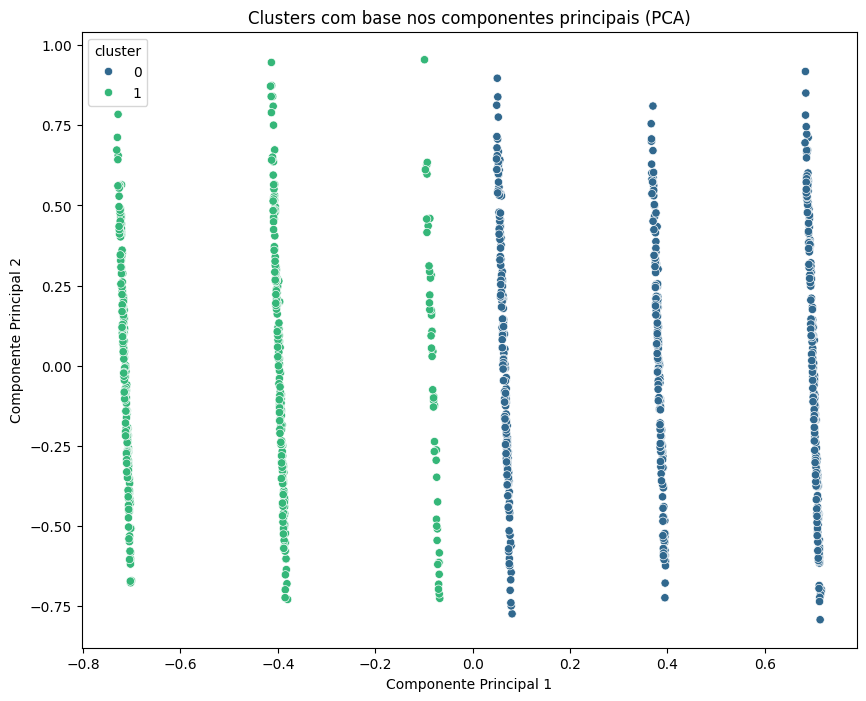

In [48]:
# Plotar o gráfico dos clusters com base nos componentes principais (PCA)
plt.figure(figsize=(10, 8))
sns.scatterplot(x='pc1', y='pc2', hue='cluster', data=dataset, palette='viridis')
plt.title('Clusters com base nos componentes principais (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

In [49]:
# Obter informações estatísticas para cada cluster
for cluster_id in dataset['cluster'].unique():
  cluster_data = dataset[dataset['cluster'] == cluster_id]
  print(f"\nInformações do Cluster {cluster_id}:")
  print(cluster_data.describe().to_string())


Informações do Cluster 0:
        ID_Viagem     Duração   Distância  Velocidade_Média  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded  ID_Viagem_minmax  Duração_minmax  Distância_minmax  Velocidade_Média_minmax  Satisfação_Usuário_minmax  Duração_encoded_minmax  Distância_encoded_minmax  Velocidade_Média_encoded_minmax  Satisfação_Usuário_encoded_minmax         pc1         pc2  cluster
count  539.000000  539.000000  539.000000        539.000000          539.000000       539.000000         539.000000                539.000000                  539.000000        539.000000      539.000000        539.000000               539.000000                 539.000000              539.000000                539.000000                       539.000000                         539.000000  539.000000  539.000000    539.0
mean   494.439703   41.205937    8.542338         15.402950            4.057514        27.636364         332.237477        

## Etapa 11: Rotulagem

In [50]:
# Verificar se a coluna 'Venda' já existe no dataset
if 'Classe' not in dataset.columns:
  # Se não existir, criar a coluna e atribuir valores iniciais (por exemplo, 'N/A')
  dataset['Classe'] = 'N/A'

# Atualizar a coluna 'Venda' com base nos clusters
dataset.loc[dataset['cluster'] == 0, 'Classe'] = 'A'
dataset.loc[dataset['cluster'] == 1, 'Classe'] = 'B'

# Exibir o dataset com a coluna 'Venda' atualizada
print("Dataset com a coluna 'Venda' atualizada:")
print(dataset.head().to_string())

Dataset com a coluna 'Venda' atualizada:
   ID_Viagem Hora_Início Hora_Fim  Duração  Distância Modo_Transporte  Velocidade_Média Condição_Tráfego       Clima  Satisfação_Usuário  Duração_encoded  Distância_encoded  Velocidade_Média_encoded  Satisfação_Usuário_encoded  ID_Viagem_minmax  Duração_minmax  Distância_minmax  Velocidade_Média_minmax  Satisfação_Usuário_minmax  Duração_encoded_minmax  Distância_encoded_minmax  Velocidade_Média_encoded_minmax  Satisfação_Usuário_encoded_minmax       pc1       pc2  cluster Classe
0          1       10:37    11:11       34       4.73            a pé              8.35         moderado  ensolarado                 4.0               24                201                       167                           4          0.000000        0.106667          0.051397                 0.030355                       0.75                0.320000                  0.285511                         0.237216                                0.8  0.390756 -0.282869      

## Etapa 12: Preparação dos Dados para o Aprendizado de Máquina

###  Balanceamento

#### Upsampled

In [51]:
# Contar a quantidade de dados para cada classe
class_counts = dataset['Classe'].value_counts()
print("Quantidade de dados para cada classe:")
print(class_counts)

# Obter a classe minoritária
minority_class = class_counts.idxmin()
# Obter a classe majoritária
majority_class = class_counts.idxmax()

# Separar os dados em conjuntos de acordo com a classe
df_majority = dataset[dataset.Classe == majority_class]
df_minority = dataset[dataset.Classe == minority_class]

# Realizar o balanceamento por meio do método de reamostragem (upsampling/oversampling) da classe minoritária
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # Amostrar com reposição
                                 n_samples=len(df_majority),  # Número de amostras igual ao da classe majoritária
                                 random_state=42)  # Seed para reprodutibilidade

# Combinar os dados majoritários e os dados minoritários reamostrados
datasetx = pd.concat([df_majority, df_minority_upsampled])

# Verificar se o balanceamento foi realizado com sucesso
print("Quantidade de dados para cada classe após balanceamento:")
print(datasetx['Classe'].value_counts())

Quantidade de dados para cada classe:
Classe
A    539
B    429
Name: count, dtype: int64
Quantidade de dados para cada classe após balanceamento:
Classe
A    539
B    539
Name: count, dtype: int64


#### Downsampled

In [52]:
# Contar a quantidade de dados para cada classe
class_counts = dataset['Classe'].value_counts()
print("Quantidade de dados para cada classe:")
print(class_counts)

# Obter a classe minoritária
minority_class = class_counts.idxmin()
print(f"\nA classe minoritária é: {minority_class}")

# Obter a classe majoritária
majority_class = class_counts.idxmax()
print(f"\nA classe majoritária é: {majority_class}")

# Separar os dados em conjuntos de acordo com a classe
df_majority = dataset[dataset['Classe'] == majority_class]
df_minority = dataset[dataset['Classe'] == minority_class]

# Realizar o balanceamento eliminando o excedente
df_majority_downsampled = resample(df_majority,
                                 replace=False,  # sample without replacement
                                 n_samples=len(df_minority),  # to match minority class
                                 random_state=123)  # reproducible results

# Combinar o conjunto de dados da classe majoritária balanceado com o conjunto da classe minoritária
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Verificar se o balanceamento foi realizado com sucesso
print("\nQuantidade de dados para cada classe após o balanceamento:")
print(df_balanced['Classe'].value_counts())

Quantidade de dados para cada classe:
Classe
A    539
B    429
Name: count, dtype: int64

A classe minoritária é: B

A classe majoritária é: A

Quantidade de dados para cada classe após o balanceamento:
Classe
A    429
B    429
Name: count, dtype: int64


### Regras

In [53]:
# Definir as regras de atribuição para as colunas
column_rules = {
    dataset.columns[0]: 'meta',  # Primeiro campo como meta
    'Classe': 'target',  # Coluna 'Classe' como target
    '*': 'feature'  # Todas as outras colunas como features
}

# Aplicar as regras às colunas do dataset
for column in dataset.columns:
  if column in column_rules:
    # Atribuir a regra específica para a coluna
    dataset.attrs[column] = column_rules[column]
  else:
    # Atribuir a regra padrão ('feature')
    dataset.attrs[column] = column_rules['*']

# Exibir as regras de atribuição
print("Regras de atribuição para as colunas:")
for column in dataset.columns:
    print(f"{column}: {dataset.attrs[column]}")

Regras de atribuição para as colunas:
ID_Viagem: meta
Hora_Início: feature
Hora_Fim: feature
Duração: feature
Distância: feature
Modo_Transporte: feature
Velocidade_Média: feature
Condição_Tráfego: feature
Clima: feature
Satisfação_Usuário: feature
Duração_encoded: feature
Distância_encoded: feature
Velocidade_Média_encoded: feature
Satisfação_Usuário_encoded: feature
ID_Viagem_minmax: feature
Duração_minmax: feature
Distância_minmax: feature
Velocidade_Média_minmax: feature
Satisfação_Usuário_minmax: feature
Duração_encoded_minmax: feature
Distância_encoded_minmax: feature
Velocidade_Média_encoded_minmax: feature
Satisfação_Usuário_encoded_minmax: feature
pc1: feature
pc2: feature
cluster: feature
Classe: target


### Separação dos Dados para Treinamento/Teste e Validação

In [54]:
# Separar os dados em treino e teste (80/20)
X = dataset.filter(regex='.*_minmax')  # Selecionar apenas colunas com sufixo '_minmax'
y = dataset['Classe']  # Definir a coluna 'Classe' como target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exibir o tamanho dos conjuntos de treino e teste
print("Tamanho do conjunto de treino:", len(X_train))
print("Tamanho do conjunto de teste:", len(X_test))

# Apresentar o conteúdo dos conjuntos de treino e teste
print("\nConteúdo do conjunto de treino (apenas Target e colunas com '_minmax'):")
print(pd.concat([y_train, X_train], axis=1).head().to_string())  # Apresentar as primeiras linhas

print("\nConteúdo do conjunto de teste (apenas Target e colunas com '_minmax'):")
print(pd.concat([y_test, X_test], axis=1).head().to_string())  # Apresentar as primeiras linhas

Tamanho do conjunto de treino: 774
Tamanho do conjunto de teste: 194

Conteúdo do conjunto de treino (apenas Target e colunas com '_minmax'):
    Classe  ID_Viagem_minmax  Duração_minmax  Distância_minmax  Velocidade_Média_minmax  Satisfação_Usuário_minmax  Duração_encoded_minmax  Distância_encoded_minmax  Velocidade_Média_encoded_minmax  Satisfação_Usuário_encoded_minmax
742      A          0.742743        0.195556          0.208224                 0.121600                       0.75                0.586667                  0.920455                         0.879261                                0.8
201      A          0.201201        0.182222          0.180416                 0.108989                       0.50                0.546667                  0.867898                         0.788352                                0.6
976      A          0.976977        0.035556          0.019900                 0.025401                       0.75                0.106667                  0.0

### Verificação dos Dados

In [55]:
# Verificar se existem valores nulos nos dados de treinamento e teste
print("Valores nulos nos dados de treinamento (X_train):")
print(X_train.isnull().sum())
print("\nValores nulos nos dados de teste (X_test):")
print(X_test.isnull().sum())

# Se existirem valores nulos, substituir pela moda de cada coluna
for column in X_train.columns:
  if X_train[column].isnull().any():
    mode_value = X_train[column].mode()[0]  # Obter a moda da coluna
    X_train[column].fillna(mode_value, inplace=True)  # Substituir valores nulos pela moda

for column in X_test.columns:
  if X_test[column].isnull().any():
    mode_value = X_test[column].mode()[0]  # Obter a moda da coluna
    X_test[column].fillna(mode_value, inplace=True)  # Substituir valores nulos pela moda

# Verificar novamente se ainda existem valores nulos após a correção
print("\nValores nulos nos dados de treinamento (X_train) após correção:")
print(X_train.isnull().sum())
print("\nValores nulos nos dados de teste (X_test) após correção:")
print(X_test.isnull().sum())

Valores nulos nos dados de treinamento (X_train):
ID_Viagem_minmax                     0
Duração_minmax                       0
Distância_minmax                     0
Velocidade_Média_minmax              0
Satisfação_Usuário_minmax            0
Duração_encoded_minmax               0
Distância_encoded_minmax             0
Velocidade_Média_encoded_minmax      0
Satisfação_Usuário_encoded_minmax    0
dtype: int64

Valores nulos nos dados de teste (X_test):
ID_Viagem_minmax                     0
Duração_minmax                       0
Distância_minmax                     0
Velocidade_Média_minmax              0
Satisfação_Usuário_minmax            0
Duração_encoded_minmax               0
Distância_encoded_minmax             0
Velocidade_Média_encoded_minmax      0
Satisfação_Usuário_encoded_minmax    0
dtype: int64

Valores nulos nos dados de treinamento (X_train) após correção:
ID_Viagem_minmax                     0
Duração_minmax                       0
Distância_minmax                   

## Etapa 13: Escolha dos Hiperparâmetros dos Modelos

### Abordagem Neural ou Conexionista

In [56]:
# Definir os hiperparâmetros para o modelo MultiLayer Perceptron
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Número de neurônios em cada camada oculta
    'activation': ['relu', 'tanh', 'logistic'],  # Função de ativação
    'solver': ['adam', 'sgd'],  # Algoritmo de otimização
    'alpha': [0.0001, 0.001, 0.01],  # Parâmetro de regularização L2
    'learning_rate': ['constant', 'adaptive'],  # Taxa de aprendizado
    'learning_rate_init': [0.001, 0.01],  # Taxa de aprendizado inicial
    'max_iter': [200, 500],  # Número máximo de iterações
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

In [57]:
# Definir os hiperparâmetros para o modelo Convolutional Neural Network
cnn_params = {
    'filters': [32, 64, 128],  # Número de filtros em cada camada convolucional
    'kernel_size': [3, 5],  # Tamanho do kernel (núcleo) da convolução
    'activation': ['relu'],  # Função de ativação nas camadas convolucionais
    'pooling': ['max'],  # Tipo de pooling (max pooling ou average pooling)
    'dropout': [0.0, 0.2, 0.5],  # Taxa de dropout para regularização
    'dense_units': [64, 128],  # Número de neurônios na camada densa
    'optimizer': ['adam', 'rmsprop'],  # Otimizador para treinamento
    'loss': ['binary_crossentropy'],  # Função de perda
    'metrics': ['accuracy'],  # Métricas para avaliação
    'epochs': [10, 20, 30],  # Número de épocas de treinamento
    'batch_size': [32, 64, 128],  # Tamanho do lote para treinamento
}

In [58]:
# Definir os hiperparâmetros para o modelo Redes Autoencoders
ae_params = {
    'input_dim': X_train.shape[1],  # Dimensão da entrada (número de features)
    'hidden_layers': [64, 32, 16],  # Número de neurônios em cada camada oculta
    'latent_dim': 8,  # Dimensão do espaço latente (tamanho do código)
    'activation': 'relu',  # Função de ativação das camadas ocultas
    'optimizer': 'adam',  # Otimizador para treinamento
    'loss': 'mse',  # Função de perda (erro quadrático médio)
    'epochs': 100,  # Número de épocas de treinamento
    'batch_size': 32,  # Tamanho do lote para treinamento
}

### Abordagem em Árvore

In [59]:
# Definir os hiperparâmetros para o modelo Decision Tree
dt_params = {
    'criterion': ['gini', 'entropy'],  # Função para medir a qualidade da divisão
    'splitter': ['best', 'random'],  # Estratégia para escolher a divisão em cada nó
    'max_depth': [None, 5, 10, 15, 20],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras necessárias para dividir um nó interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras necessárias em cada folha
    'max_features': [None, 'sqrt', 'log2'],  # Número de features a serem consideradas para cada divisão
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

In [60]:
# Definir os hiperparâmetros para o modelo Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],  # Número de árvores na floresta
    'criterion': ['gini', 'entropy'],  # Função para medir a qualidade da divisão
    'max_depth': [None, 10, 20, 30],  # Profundidade máxima da árvore
    'min_samples_split': [2, 5, 10],  # Número mínimo de amostras para dividir um nó
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt', 'log2'],  # Número máximo de features a serem consideradas para dividir um nó
    'bootstrap': [True, False],  # Usar bootstrap para criar as amostras para as árvores
    'class_weight': ['balanced', None],  # Tratamento de classes desbalanceadas
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

In [61]:
# Definir os hiperparâmetros para o modelo Light Gradient Boosting Machine
lgbm_params = {
    'learning_rate': [0.01, 0.1, 0.2],  # Taxa de aprendizado
    'n_estimators': [50, 100, 200],  # Número de estimadores (árvores)
    'max_depth': [3, 5, 7],  # Profundidade máxima da árvore
    'num_leaves': [31, 63, 127],  # Número máximo de folhas em cada árvore
    'boosting_type': ['gbdt', 'dart'],  # Tipo de boosting
    'objective': ['binary'],  # Função objetivo (classificação binária)
    'metric': ['binary_logloss', 'auc'],  # Métricas para avaliar o modelo
    'subsample': [0.8, 1.0],  # Fração de amostras usadas para treinamento de cada árvore
    'colsample_bytree': [0.8, 1.0],  # Fração de features usadas para treinamento de cada árvore
    'reg_alpha': [0, 0.1, 0.5],  # Regularização L1
    'reg_lambda': [0, 0.1, 0.5],  # Regularização L2
    'random_state': [42]  # Seed para reprodutibilidade dos resultados
}

### Abordagem Estatística

In [62]:
# Definir os hiperparâmetros para o modelo Support Vector Machine
svm_params = {
    'C': [0.1, 1, 10, 100],  # Parâmetro de regularização
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Tipo de kernel
    'gamma': ['scale', 'auto'],  # Parâmetro do kernel RBF, polinomial e sigmoid
    'degree': [2, 3, 4],  # Grau do kernel polinomial
    'class_weight': ['balanced', None],  # Tratamento de classes desbalanceadas
}

In [63]:
# Definir os hiperparâmetros para o modelo K-Nearest Neighbors
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],  # Número de vizinhos mais próximos
    'weights': ['uniform', 'distance'],  # Tipo de ponderação dos vizinhos
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmo para calcular os vizinhos mais próximos
    'leaf_size': [10, 20, 30, 40],  # Tamanho das folhas para ball_tree e kd_tree
    'p': [1, 2]  # Parâmetro da métrica de distância (1 para distância de Manhattan, 2 para distância euclidiana)
}

In [64]:
# Definir os hiperparâmetros para o modelo Logistic Regression
lor_params = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  # Tipo de regularização
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Parâmetro de regularização (inverso da força da regularização)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Algoritmo para otimização
    'max_iter': [100, 200, 300],  # Número máximo de iterações
    'multi_class': ['auto', 'ovr', 'multinomial'],  # Método para lidar com problemas multiclasse
}

### Otimização dos Hiperparâmetros

In [ ]:
# Criar um dicionário com os modelos e seus hiperparâmetros correspondentes
#models = {
#    'MLP': (MLPClassifier(), mlp_params),
#    'DT': (DecisionTreeClassifier(), dt_params),
#    'RF': (RandomForestClassifier(), rf_params),
#    'LGBM': (LGBMClassifier(), lgbm_params),
#    'SVM': (SVC(), svm_params),
#    'KNN': (KNeighborsClassifier, knn_params),
#    'LOR': (LogisticRegression(), lor_params)
#}

# Criar um dicionário com os modelos e seus hiperparâmetros correspondentes
models = {
    'MLP': (MLPClassifier(), mlp_params),
    'LGBM': (LGBMClassifier(), lgbm_params),
    'SVM': (SVC(), svm_params)
}

# Definir a estratégia de validação cruzada
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Loop para otimizar os hiperparâmetros de cada modelo
for model_name, (model, params) in models.items():
    print(f"Otimizando hiperparâmetros para o modelo: {model_name}")

    # Criar o objeto GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=cv, scoring='accuracy', n_jobs=-1)

    # Ajustar o GridSearchCV aos dados de treinamento
    grid_search.fit(X_train, y_train)

    # Imprimir os melhores hiperparâmetros encontrados
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

    # Avaliar o modelo com os melhores hiperparâmetros no conjunto de teste
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calcular as métricas de avaliação
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Métricas para {model_name} com melhores hiperparâmetros:")
    print(f"Acurácia: {accuracy:.4f}")
    print(f"Precisão: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Salvar o modelo com os melhores hiperparâmetros (opcional)
    filename = f'{model_name}_best_model.pkl'
    pickle.dump(best_model, open(filename, 'wb'))

NameError: name 'svm_params' is not defined

## Etapa 14: Competição de Modelos

### Multilayer Perceptron (MLP)

In [65]:
# Criar um modelo MLP com hiperparâmetros específicos
mlp_model = MLPClassifier(
    hidden_layer_sizes=(32,),  # Número de neurônios em cada camada oculta
    activation='relu',  # Função de ativação
    solver='adam',  # Algoritmo de otimização
    alpha=0.0001,  # Termo de regularização L2
    batch_size='auto',  # Tamanho do batch para o treinamento
    learning_rate='constant',  # Taxa de aprendizado
    learning_rate_init=0.001,  # Taxa de aprendizado inicial
    power_t=0.5,  # Parâmetro para o algoritmo de otimização 'sgd'
    max_iter=200,  # Número máximo de iterações
    shuffle=True,  # Embaralhar os dados a cada época
    random_state=None,  # Semente aleatória
    tol=0.0001,  # Tolerância para o critério de parada
    verbose=False,  # Mostrar mensagens durante o treinamento
    warm_start=False,  # Reutilizar a solução da inicialização anterior
    momentum=0.9,  # Parâmetro para o algoritmo de otimização 'sgd'
    nesterovs_momentum=True,  # Utilizar o momentum de Nesterov
    early_stopping=False,  # Parar o treinamento precocemente
    validation_fraction=0.1,  # Fração de dados para validação
    beta_1=0.9,  # Parâmetro para o algoritmo de otimização 'adam'
    beta_2=0.999,  # Parâmetro para o algoritmo de otimização 'adam'
    epsilon=1e-08,  # Parâmetro para o algoritmo de otimização 'adam'
    n_iter_no_change=10,  # Número máximo de épocas sem melhoria
    max_fun=1000  # Número máximo de chamadas para a função de custo
)

# Exibir os hiperparâmetros
print("Hiperparâmetros do modelo MLP:")
print(mlp_model.get_params())

Hiperparâmetros do modelo MLP:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (32,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 1000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': None, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


In [66]:
# Treinar e avaliar o modelo com validação cruzada
cv_scores = cross_val_score(mlp_model, X_train, y_train, cv=3, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print("Resultados da validação cruzada para o modelo:")
print("Acurácia para cada fold:", cv_scores)
print("Acurácia média:", cv_scores.mean())
print("Desvio padrão da acurácia:", cv_scores.std())

# Treinar o modelo com os dados de treinamento completos
mlp_model.fit(X_train, y_train)

# Fazer previsões com o modelo no conjunto de teste
y_pred_mlp = mlp_model.predict(X_test)

# Calcular as métricas de avaliação para o modelo
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp, average='weighted')
recall_mlp = recall_score(y_test, y_pred_mlp, average='weighted')
f1_mlp = f1_score(y_test, y_pred_mlp, average='weighted')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Resultados da validação cruzada para o modelo:
Acurácia para cada fold: [0.94573643 0.99612403 0.97286822]
Acurácia média: 0.9715762273901808
Desvio padrão da acurácia: 0.020590926938642402


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### Light Gradient Boosting Machine (LGBM)

In [67]:
# Criar um modelo LGBM com hiperparâmetros específicos
lgbm_model = LGBMClassifier(
    learning_rate=0.1,  # Taxa de aprendizado
    n_estimators=100,  # Número de estimadores (árvores)
    max_depth=7,  # Profundidade máxima da árvore
    num_leaves=127,  # Número máximo de folhas em cada árvore
    boosting_type='gbdt',  # Tipo de boosting
    objective='binary',  # Função objetivo (classificação binária)
    metric='binary_logloss',  # Métricas para avaliar o modelo
    subsample=0.8,  # Fração de amostras usadas para treinamento de cada árvore
    colsample_bytree=0.8,  # Fração de features usadas para treinamento de cada árvore
    reg_alpha=0.1,  # Regularização L1
    reg_lambda=0.1,  # Regularização L2
    random_state=42  # Seed para reprodutibilidade dos resultados
)

# Exibir os hiperparâmetros
print("Hiperparâmetros do modelo LGBM:")
print(lgbm_model.get_params())

Hiperparâmetros do modelo LGBM:
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 7, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 127, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'binary_logloss'}


In [68]:
# Treinar e avaliar o modelo com validação cruzada
cv_scores = cross_val_score(lgbm_model, X_train, y_train, cv=3, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print("Resultados da validação cruzada para o modelo LGBM:")
print("Acurácia para cada fold:", cv_scores)
print("Acurácia média:", cv_scores.mean())
print("Desvio padrão da acurácia:", cv_scores.std())

# Treinar o modelo com os dados de treinamento completos
lgbm_model.fit(X_train, y_train)

# Fazer previsões com o modelo no conjunto de teste
y_pred_lgbm = lgbm_model.predict(X_test)

# Calcular as métricas de avaliação para o modelo
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
precision_lgbm = precision_score(y_test, y_pred_lgbm, average='weighted')
recall_lgbm = recall_score(y_test, y_pred_lgbm, average='weighted')
f1_lgbm = f1_score(y_test, y_pred_lgbm, average='weighted')

[LightGBM] [Info] Number of positive: 223, number of negative: 293
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000732 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 983
[LightGBM] [Info] Number of data points in the train set: 516, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432171 -> initscore=-0.273001
[LightGBM] [Info] Start training from score -0.273001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Support Vector Machine (SVM)

In [69]:
# Criar modelo SVM com hiperparâmetros específicos
svm_model = SVC(
    C=1.0,  # Parâmetro de regularização (custo da classificação incorreta)
    kernel='rbf',  # Kernel para o modelo (radial basis function)
    degree=3,  # Grau do polinômio para o kernel (relevante para kernel='poly')
    gamma='scale',  # Coeficiente do kernel (relevante para kernel='rbf', 'poly', 'sigmoid')
    coef0=0.0,  # Termo independente para o kernel (relevante para kernel='poly', 'sigmoid')
    shrinking=True,  # Utilização do shrinking heuristic para otimizar a solução
    probability=False,  # Calcular probabilidades de classe
    tol=0.001,  # Tolerância para a otimização
    cache_size=200,  # Tamanho do cache em MB
    class_weight=None,  # Pesos para as classes (pode ser usado para lidar com classes desbalanceadas)
    verbose=False,  # Mostrar mensagens durante a execução
    max_iter=200,  # Número máximo de iterações para a otimização (-1 significa ilimitado)
    decision_function_shape='ovr',  # Formato da função de decisão ('ovo' para one-vs-one, 'ovr' para one-vs-rest)
    break_ties=False,  # Quebrar empates com maior precisão (relevante para classificação multiclasse)
    random_state=None  # Semente aleatória para reprodutibilidade
)

# Exibir os hiperparâmetros
print("Hiperparâmetros do modelo SVM:")
print(svm_model.get_params())

Hiperparâmetros do modelo SVM:
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': 200, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


In [70]:
# Treinar e avaliar o modelo com validação cruzada
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=3, scoring='accuracy')

# Imprimir os resultados da validação cruzada
print("Resultados da validação cruzada para o modelo:")
print("Acurácia para cada fold:", cv_scores)
print("Acurácia média:", cv_scores.mean())
print("Desvio padrão da acurácia:", cv_scores.std())

# Treinar o modelo com os dados de treinamento completos
svm_model.fit(X_train, y_train)

# Fazer previsões com o modelo no conjunto de teste
y_pred_svm = svm_model.predict(X_test)

# Calcular as métricas de avaliação para o modelo
accuracy_svm = accuracy_score(y_test, y_pred_mlp)
precision_svm = precision_score(y_test, y_pred_mlp, average='weighted')
recall_svm = recall_score(y_test, y_pred_mlp, average='weighted')
f1_svm = f1_score(y_test, y_pred_mlp, average='weighted')

Resultados da validação cruzada para o modelo:
Acurácia para cada fold: [0.99612403 1.         1.        ]
Acurácia média: 0.9987080103359173
Desvio padrão da acurácia: 0.0018271493053915989


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Avaliação das Métricas

In [71]:
# Imprimir as métricas de avaliação para o modelo
print("\nMétricas de avaliação para o modelo MLP:")
print("Acurácia:", accuracy_mlp)
print("Precisão:", precision_mlp)
print("Revocação:", recall_mlp)
print("Mensuraçao:", f1_mlp)

# Imprimir as métricas de avaliação para o modelo
print("\nMétricas de avaliação para o modelo LGBM:")
print("Acurácia:", accuracy_lgbm)
print("Precisão:", precision_lgbm)
print("Revocação:", recall_lgbm)
print("Mensuraçao:", f1_lgbm)

# Imprimir as métricas de avaliação para o modelo
print("\nMétricas de avaliação para o modelo SVM:")
print("Acurácia:", accuracy_svm)
print("Precisão:", precision_svm)
print("Revocação:", recall_svm)
print("Mensuraçao:", f1_svm)


Métricas de avaliação para o modelo MLP:
Acurácia: 0.9690721649484536
Precisão: 0.9708394698085421
Revocação: 0.9690721649484536
Mensuraçao: 0.9690227278719645

Métricas de avaliação para o modelo LGBM:
Acurácia: 1.0
Precisão: 1.0
Revocação: 1.0
Mensuraçao: 1.0

Métricas de avaliação para o modelo SVM:
Acurácia: 0.9690721649484536
Precisão: 0.9708394698085421
Revocação: 0.9690721649484536
Mensuraçao: 0.9690227278719645


In [72]:
# Criar um DataFrame para armazenar as métricas de cada modelo
metricas_modelos = pd.DataFrame({
    'Modelo': ['MLP', 'LGBM', 'SVM'],
    'Acurácia': [accuracy_mlp, accuracy_lgbm, accuracy_svm],
    'Precisão': [precision_mlp, precision_lgbm, precision_svm],
    'Revocação': [recall_mlp, recall_lgbm, recall_svm],
    'Mensuração': [f1_mlp, f1_lgbm, f1_svm]
})

# Exibir as métricas de cada modelo
print("\nMétricas dos Modelos:")
print(metricas_modelos)

# Encontrar o modelo com a maior acurácia
melhor_modelo_acuracia = metricas_modelos.loc[metricas_modelos['Acurácia'].idxmax()]
print(f"\nMelhor modelo com base na Acurácia: {melhor_modelo_acuracia['Modelo']}")

# Encontrar o modelo com o maior Precisão
melhor_modelo_precisao = metricas_modelos.loc[metricas_modelos['Precisão'].idxmax()]
print(f"\nMelhor modelo com base no Precisão: {melhor_modelo_precisao['Modelo']}")

# Encontrar o modelo com o maior Revocação
melhor_modelo_revocacao = metricas_modelos.loc[metricas_modelos['Revocação'].idxmax()]
print(f"\nMelhor modelo com base no Revocação: {melhor_modelo_precisao['Modelo']}")

# Encontrar o modelo com o maior Mensuração
melhor_modelo_mensuracao = metricas_modelos.loc[metricas_modelos['Mensuração'].idxmax()]
print(f"\nMelhor modelo com base no Mensuração: {melhor_modelo_mensuracao['Modelo']}")

# Avaliar o melhor modelo com base em múltiplas métricas (exemplo: média ponderada de Acurácia e F1-Score)
metricas_modelos['Pontuacao_Media'] = (metricas_modelos['Acurácia'] + metricas_modelos['Precisão']  + metricas_modelos['Revocação'] + metricas_modelos['Mensuração']) / 4
melhor_modelo_media = metricas_modelos.loc[metricas_modelos['Pontuacao_Media'].idxmax()]
print(f"\nMelhor modelo com base na média ponderada de Acurácia, Precisão, Revocação e Mensuração: {melhor_modelo_media['Modelo']}")



Métricas dos Modelos:
  Modelo  Acurácia  Precisão  Revocação  Mensuração
0    MLP  0.969072  0.970839   0.969072    0.969023
1   LGBM  1.000000  1.000000   1.000000    1.000000
2    SVM  0.969072  0.970839   0.969072    0.969023

Melhor modelo com base na Acurácia: LGBM

Melhor modelo com base no Precisão: LGBM

Melhor modelo com base no Revocação: LGBM

Melhor modelo com base no Mensuração: LGBM

Melhor modelo com base na média ponderada de Acurácia, Precisão, Revocação e Mensuração: LGBM


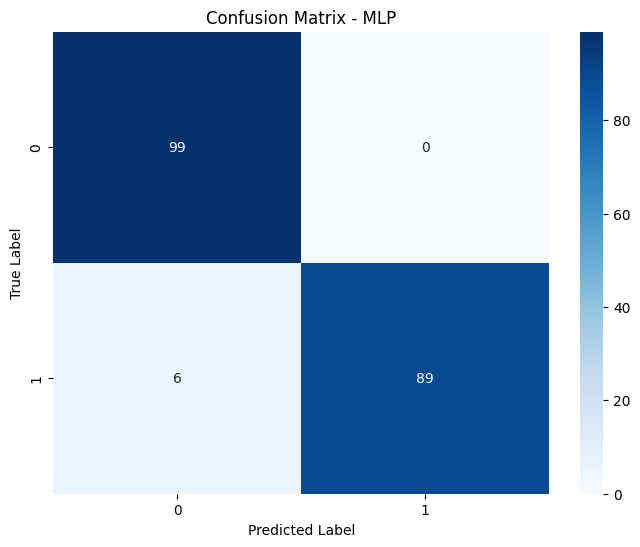

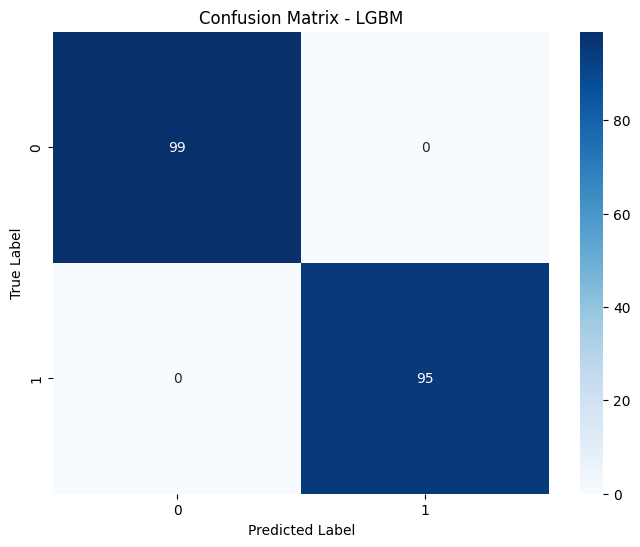

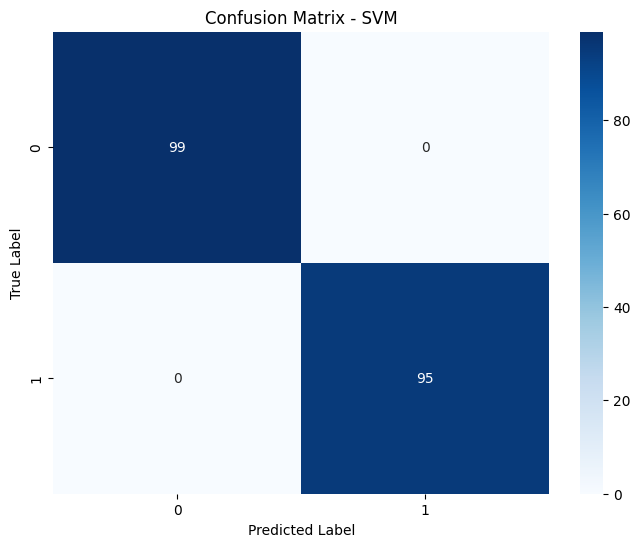

In [73]:
# Gerar matrizes de confusão para cada modelo
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_lgbm = confusion_matrix(y_test, y_pred_lgbm)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Função para plotar matriz de confusão
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Matrizes de confusão de plotagem para cada modelo
plot_confusion_matrix(cm_mlp, 'MLP')
print()
plot_confusion_matrix(cm_lgbm, 'LGBM')
print()
plot_confusion_matrix(cm_svm, 'SVM')

### Salvar Modelo Campeão

In [74]:
# Salvar o modelo campeão treinado
filename = 'model.pkl'
pickle.dump(lgbm_model, open(filename, 'wb'))

## Etapa 15: Validação do Modelo

### Modelo

In [75]:
# Carregar o modelo salvo
filename = 'model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

### Validação


Métricas de avaliação para o modelo carregado:
Acurácia: 1.0
Precisão: 1.0
Revocação: 1.0
F1-Score: 1.0


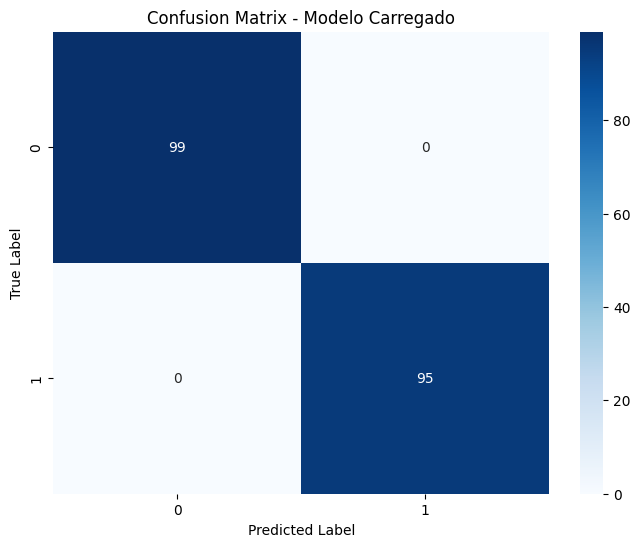

In [76]:
# Avaliar o modelo carregado no conjunto de teste
y_pred = loaded_model.predict(X_test)

# Calcular as métricas de avaliação para o modelo
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Imprimir as métricas de avaliação
print("\nMétricas de avaliação para o modelo carregado:")
print("Acurácia:", accuracy)
print("Precisão:", precision)
print("Revocação:", recall)
print("F1-Score:", f1)

# Gerar a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plot_confusion_matrix(cm, 'Modelo Carregado')